***TITLE: FN-NET LIGHTWEIGHT CNN MODEL FOR FABRIC DEFECT DETECTION***

***IMPORT LIBRARIES***

In [1]:
# %%


import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold 

2025-08-08 08:54:41.578857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 08:54:41.590733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754643281.605941   62702 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754643281.610459   62702 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 08:54:41.629010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import matplotlib.pyplot as plt
import cv2
import shutil
import numpy as np


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

***DATA PREPROCESSING***

**1)** **DATASET IMPORTING**

In [3]:
from tensorflow.keras.utils import Sequence
from glob import glob
import cv2
import numpy as np
import os

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size, num_classes, shuffle=True, class_indices=None):
        self.image_paths = image_paths
        self.labels = labels
        self.classes = np.array(labels)
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.class_indices = class_indices or self._build_class_indices(labels)
        self.on_epoch_end()
        self.current_index=0
        
    def __iter__(self):
        """Initialize the iterator."""
        self.current_index = 0
        return self

    def __next__(self):
        """Get the next batch."""
        if self.current_index >= len(self):
            # End of epoch
            self.on_epoch_end()
            self.current_index = 0
            raise StopIteration
        
        batch = self.__getitem__(self.current_index)
        self.current_index += 1
        return batch
    
    
    def reset(self):
        """Reset the generator for the next epoch."""
        self.current_index = 0
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = map(list, zip(*combined))  # Convert back to lists
            self.classes = np.array(self.labels)  # Update classes array as well
    
    def _build_class_indices(self, labels):
        unique_labels = sorted(set(labels))
        return {str(lbl): lbl for lbl in unique_labels}

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0
            stacked =np.stack([img], axis=-1)
            batch_images.append(stacked)

        batch_images = np.array(batch_images)
        batch_labels = tf.keras.utils.to_categorical(batch_labels, self.num_classes)

        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_paths, self.labels))
            np.random.shuffle(combined)
            self.image_paths, self.labels = map(list, zip(*combined))  # Convert back to lists
            self.classes = np.array(self.labels)  # Update classes array as well


In [4]:
# %%
train_dir = "/mnt/c/newTrainHV/Train"

test_dir = "/mnt/c/newTrainHV/Test"

In [5]:
from sklearn.preprocessing import LabelEncoder

def get_filepaths_and_labels(directory):
    class_names = sorted(os.listdir(directory))
    filepaths = []
    labels = []

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in glob(os.path.join(class_dir, "*")):
            filepaths.append(fname)
            labels.append(class_name)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    class_indices = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    return filepaths, encoded_labels, len(label_encoder.classes_), label_encoder,class_indices
# Image parameters
IMG_SIZE = (256,256 )  # Image size
BATCH_SIZE = 40       # Number of images in each batch
# Train

train_filepaths, train_labels, NUM_CLASSES, label_encoder,class_indices = get_filepaths_and_labels(train_dir)
test_filepaths, test_labels, _, _,_ = get_filepaths_and_labels(test_dir)

# Combine for full dataset cross-validation
all_filepaths = np.array(train_filepaths + test_filepaths)
all_labels = np.array(train_labels.tolist() + test_labels.tolist())

from sklearn.model_selection import train_test_split

# Split the combined data into 95% train set and 5% final test set
X_train_main, X_test_final, y_train_main, y_test_final = train_test_split(
    all_filepaths,
    all_labels,
    test_size=0.05,
    stratify=all_labels,  # Maintain class balance
    random_state=42
)

train_generator = CustomDataGenerator(X_train_main, y_train_main, BATCH_SIZE, IMG_SIZE, NUM_CLASSES,class_indices=class_indices)
test_generator = CustomDataGenerator( X_test_final, y_test_final, BATCH_SIZE, IMG_SIZE, NUM_CLASSES, shuffle=False,class_indices=class_indices)


**2) DATASET STATISTICS AND VISUALIZATION**

In [6]:
# %%
train_set= train_generator
test_set= test_generator
print("Class Indices:", train_set.class_indices)
print("Number of Classes:", train_set.num_classes)
print("Number of Classes:", test_set.num_classes)
from collections import Counter
print(Counter(train_set.classes))
print(Counter(test_set.classes))

Class Indices: {'No_Defect': 0, 'horizontal_line': 1, 'stain': 2, 'tear': 3, 'vertical_line': 4}
Number of Classes: 5
Number of Classes: 5
Counter({3: 1341, 0: 1333, 1: 646, 4: 639, 2: 601})
Counter({3: 71, 0: 70, 1: 34, 4: 33, 2: 32})


***MODEL CREATION***

In [7]:
# Parameters
INPUT_SHAPE = (256, 256, 1)  # Input size of images
NUM_CLASSES =  train_generator.num_classes             # many class
LEARNING_RATE = 0.001
EPOCHS = 100                 # Increased epochs
BATCH_SIZE = 40

In [8]:
from keras.saving import register_keras_serializable
from tensorflow.keras.layers import Layer
import tensorflow as tf

@register_keras_serializable()
class SimAM(Layer):
    def __init__(self, e_lambda=1e-4, **kwargs):
        super(SimAM, self).__init__(**kwargs)
        self.e_lambda = e_lambda

    def call(self, x):
        mean = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        var = tf.reduce_mean(tf.square(x - mean), axis=[1, 2], keepdims=True)
        attention = tf.sigmoid((x - mean) / tf.sqrt(var + self.e_lambda))
        return x * attention


In [9]:
import tensorflow as tf

# Define quantization functions
def fake_quantize(x, bits=8, min_value=None, max_value=None):
    if min_value is None:
        min_value = tf.reduce_min(x)
    if max_value is None:
        max_value = tf.reduce_max(x)
    
    # Ensure min doesn't equal max to prevent division by zero
    max_value = tf.maximum(max_value, min_value + 1e-6)
    
    # Calculate the step size (the value of 1 bit)
    step = (max_value - min_value) / (2**bits - 1)
    
    # Quantize the values
    x_int = tf.round((x - min_value) / step)
    
    # Clip values to the quantization range
    x_int = tf.clip_by_value(x_int, 0, 2**bits - 1)
    
    # Convert back to original range
    x_q = x_int * step + min_value
    
    # During training, pass through the gradients using STE (Straight Through Estimator)
    return x + tf.stop_gradient(x_q - x)

@tf.keras.utils.register_keras_serializable()
class QuantizedConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding='same', strides=1, activation=None, weight_bits=8, activation_bits=8, **kwargs):
        super(QuantizedConv2D, self).__init__(**kwargs)
        self.filters = int(filters)
        # Ensure kernel_size is stored as a tuple of integers
        if isinstance(kernel_size, int):
            self.kernel_size = (int(kernel_size), int(kernel_size))
        else:
            self.kernel_size = (int(kernel_size[0]), int(kernel_size[1]))
        self.padding = padding
        if isinstance(strides, int):
            self.strides = (int(strides), int(strides))
        else:
            self.strides = (int(strides[0]), int(strides[1]))
        self.activation_fn = tf.keras.activations.get(activation)
        self.weight_bits = int(weight_bits)
        self.activation_bits = int(activation_bits)
        
    def build(self, input_shape):
        input_channels = int(input_shape[-1])
        kernel_size = tuple(self.kernel_size)
        kernel_shape = kernel_shape = (
            int(self.kernel_size[0]),
            int(self.kernel_size[1]),
            int(input_channels),
            int(self.filters)
            )
        self.kernel = self.add_weight(
            name='kernel',
            shape=kernel_shape,
            initializer='glorot_uniform',
            trainable=True
        )
        
        self.bias = self.add_weight(
            name='bias',
            shape=(self.filters,),
            initializer='zeros',
            trainable=True
        )
        
        # Track min and max values for weights (needed for quantization)
        self.w_min = self.add_weight(
            name='w_min',
            shape=(1,),
            initializer=tf.constant_initializer(-1.0),
            trainable=False
        )
        
        self.w_max = self.add_weight(
            name='w_max',
            shape=(1,),
            initializer=tf.constant_initializer(1.0),
            trainable=False
        )
        
        # Track min and max values for activations
        self.a_min = self.add_weight(
            name='a_min',
            shape=(1,),
            initializer=tf.constant_initializer(0.0),
            trainable=False
        )
        
        self.a_max = self.add_weight(
            name='a_max',
            shape=(1,),
            initializer=tf.constant_initializer(6.0),  # ReLU typically has max around 6
            trainable=False
        )
        
        self.built = True
    
    def call(self, inputs, training=None):
        if training:
            curr_w_min = tf.reduce_min(self.kernel)
            curr_w_max = tf.reduce_max(self.kernel)
            
            # Use EMA (Exponential Moving Average) to update min/max values
            momentum = 0.9
            self.w_min.assign(momentum * self.w_min + (1 - momentum) * curr_w_min)
            self.w_max.assign(momentum * self.w_max + (1 - momentum) * curr_w_max)
        
        # Quantize weights
        quantized_kernel = fake_quantize(
            self.kernel, 
            bits=self.weight_bits,
            min_value=self.w_min,
            max_value=self.w_max
        )
        
        # Standard convolution with quantized weights
        outputs = tf.nn.conv2d(
            inputs,
            quantized_kernel,
            strides=[1, self.strides[0], self.strides[1], 1],
            padding=self.padding.upper()
        )
        
        outputs = tf.nn.bias_add(outputs, self.bias)
        
        # Apply activation if specified
        if self.activation_fn is not None:
            outputs = self.activation_fn(outputs)
            
            # Update activation min/max during training
            if training:
                curr_a_min = tf.reduce_min(outputs)
                curr_a_max = tf.reduce_max(outputs)
                
                # Use EMA to update min/max values
                momentum = 0.9
                self.a_min.assign(momentum * self.a_min + (1 - momentum) * curr_a_min)
                self.a_max.assign(momentum * self.a_max + (1 - momentum) * curr_a_max)
            
            # Quantize activations
            outputs = fake_quantize(
                outputs,
                bits=self.activation_bits,
                min_value=self.a_min,
                max_value=self.a_max
            )
        
        return outputs

    def get_config(self):
        config = super(QuantizedConv2D, self).get_config()
        config.update({
            'filters': int(self.filters),  # Ensure filters is serialized as int
            'kernel_size': (int(self.kernel_size[0]), int(self.kernel_size[1])),  # Ensure tuple of ints
            'padding': self.padding,
            'strides': (int(self.strides[0]), int(self.strides[1])),  # Ensure tuple of ints
            'activation': tf.keras.activations.serialize(self.activation_fn),
            'weight_bits': int(self.weight_bits),
            'activation_bits': int(self.activation_bits)
        })
        return config

@tf.keras.utils.register_keras_serializable()
class QuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, weight_bits=8, activation_bits=8, **kwargs):
        super(QuantizedDense, self).__init__(**kwargs)
        self.units = units
        self.activation_fn = tf.keras.activations.get(activation)
        self.weight_bits = weight_bits
        self.activation_bits = activation_bits
        
    def build(self, input_shape):
        input_dim = input_shape[-1]
        
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        
        self.bias = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        
        # Track min and max values for weights
        self.w_min = self.add_weight(
            name='w_min',
            shape=(1,),
            initializer=tf.constant_initializer(-1.0),
            trainable=False
        )
        
        self.w_max = self.add_weight(
            name='w_max',
            shape=(1,),
            initializer=tf.constant_initializer(1.0),
            trainable=False
        )
        
        # Track min and max values for activations
        self.a_min = self.add_weight(
            name='a_min',
            shape=(1,),
            initializer=tf.constant_initializer(0.0),
            trainable=False
        )
        
        self.a_max = self.add_weight(
            name='a_max',
            shape=(1,),
            initializer=tf.constant_initializer(6.0),
            trainable=False
        )
        
        self.built = True
    
    def call(self, inputs, training=None):
        if training:
            curr_w_min = tf.reduce_min(self.kernel)
            curr_w_max = tf.reduce_max(self.kernel)
            
            # Use EMA to update min/max values
            momentum = 0.9
            self.w_min.assign(momentum * self.w_min + (1 - momentum) * curr_w_min)
            self.w_max.assign(momentum * self.w_max + (1 - momentum) * curr_w_max)
        
        # Quantize weights
        quantized_kernel = fake_quantize(
            self.kernel,
            bits=self.weight_bits,
            min_value=self.w_min,
            max_value=self.w_max
        )
        
        # Standard dense operation with quantized weights
        outputs = tf.matmul(inputs, quantized_kernel)
        outputs = tf.nn.bias_add(outputs, self.bias)
        
        # Apply activation if specified
        if self.activation_fn is not None:
            outputs = self.activation_fn(outputs)
            
            # Update activation min/max during training
            if training:
                curr_a_min = tf.reduce_min(outputs)
                curr_a_max = tf.reduce_max(outputs)
                
                # Use EMA to update min/max values
                momentum = 0.9
                self.a_min.assign(momentum * self.a_min + (1 - momentum) * curr_a_min)
                self.a_max.assign(momentum * self.a_max + (1 - momentum) * curr_a_max)
            
            # Quantize activations
            outputs = fake_quantize(
                outputs,
                bits=self.activation_bits,
                min_value=self.a_min,
                max_value=self.a_max
            )
        
        return outputs
    
    def get_config(self):
        config = super(QuantizedDense, self).get_config()
        config.update({
            'units': self.units,
            'activation': tf.keras.activations.serialize(self.activation_fn),
            'weight_bits': self.weight_bits,
            'activation_bits': self.activation_bits
        })
        return config
    

In [10]:
# load the model with custom_objects
custom_objects = {
    'QuantizedConv2D': QuantizedConv2D,
    'QuantizedDense': QuantizedDense,
    'SimAM': SimAM
}

In [11]:
# %%
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout

# Step 2: Define CNN Model

def create_cnn_model(input_shape=(128, 128, 1), num_classes=NUM_CLASSES):
    """
    Creates the FN-Net model as described in the paper.
    
    Args:
        input_shape: Tuple of (height, width, channels). Default is (128, 128, 1) for grayscale
        num_classes: Number of output classes. Default is 2 for binary classification
        
    Returns:
        Keras Sequential model
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(6, 6), strides=6),
        
        # Second Convolutional Block
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=3),
        
        # Third Convolutional Block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        # Fourth Convolutional Block
        Conv2D(96, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        
        # Flatten layer
        Flatten(),
        # First Dense Layer with Dropout
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        # Second Dense Layer
        Dense(256, activation='relu'),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model


# %%

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, Multiply, Activation, Flatten, Reshape, Permute
)
import tensorflow.keras.backend as K

def attention_block(x):
    """
    Applies a channel-wise attention mechanism to the input tensor.
    
    Args:
        x: Input tensor of shape (batch_size, h, w, c)
    
    Returns:
        Tensor after applying attention
    """
    # Global context vector (channel-wise average pooling)
    avg_pool = GlobalAveragePooling2D()(x)  # shape: (batch_size, channels)
    
    # Learn attention weights per channel
    attention = Dense(K.int_shape(x)[-1], activation='tanh')(avg_pool)  # shape: (batch_size, channels)
    attention = Activation('sigmoid')(attention)  # Optionally, use 'softmax' or 'tanh'
    
    # Reshape to multiply with input
    attention = Reshape((1, 1, K.int_shape(x)[-1]))(attention)  # shape: (batch_size, 1, 1, channels)
    
    # Apply attention weights to original feature maps
    return Multiply()([x, attention])

def create_cnn_model_with_attention(input_shape=(128, 128, 1), num_classes=2):
    inputs = Input(shape=input_shape)
    
    # Convolutional Blocks
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(6, 6), strides=6)(x)
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=3)(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    
    x = Conv2D(96, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    
    # Attention Block
    x = attention_block(x)
    
    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)


**QUANTIZATION AWARE TRAINING (QAT)**

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, Reshape, Multiply
from tensorflow.keras import backend as K

def quantized_attention_block(x):
    """
    Applies a channel-wise attention mechanism using QuantizedDense for QAT.
    
    Args:
        x: Input tensor of shape (batch_size, h, w, c)
    
    Returns:
        Tensor after applying attention
    """
    # Global context vector (channel-wise average pooling)
    avg_pool = GlobalAveragePooling2D()(x)  # shape: (batch_size, channels)

    # Learn attention weights per channel using QuantizedDense
    attention = QuantizedDense(K.int_shape(x)[-1], activation='tanh')(avg_pool)  # shape: (batch_size, channels)
    attention = Activation('sigmoid')(attention)  # Optionally, use 'softmax' or 'tanh'

    # Reshape to multiply with input
    attention = Reshape((1, 1, K.int_shape(x)[-1]))(attention)  # shape: (batch_size, 1, 1, channels)

    # Apply attention weights to original feature maps
    return Multiply()([x, attention])


In [14]:
def create_quantized_cnn_model(input_shape=(128, 128, 1), num_classes=10, weight_bits=8, activation_bits=8):
    """
    Creates a quantization-aware version of the model
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    # First Convolutional Block
    x = QuantizedConv2D(16, (3, 3), padding='same', activation='relu', 
                        weight_bits=weight_bits, activation_bits=activation_bits)(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(6, 6), strides=6)(x)
    
    # Second Convolutional Block
    x = QuantizedConv2D(32, (3, 3), padding='same', activation='relu',
                        weight_bits=weight_bits, activation_bits=activation_bits)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=3)(x)
    
    # Third Convolutional Block
    x = QuantizedConv2D(64, (3, 3), padding='same', activation='relu',
                        weight_bits=weight_bits, activation_bits=activation_bits)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    
    # Fourth Convolutional Block
    x = QuantizedConv2D(96, (3, 3), padding='same', activation='relu',
                        weight_bits=weight_bits, activation_bits=activation_bits)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    # Flatten layer
    x = tf.keras.layers.Flatten()(x)
    
    # First Dense Layer with Dropout
    x = QuantizedDense(512, activation='relu',
                      weight_bits=weight_bits, activation_bits=activation_bits)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Second Dense Layer
    x = QuantizedDense(256, activation='relu',
                      weight_bits=weight_bits, activation_bits=activation_bits)(x)
    
    # Output Layer 
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

**OPTIMIZERS AND CALLBACK DEFINITIONS**

In [15]:
# Create the model
model = create_quantized_cnn_model(INPUT_SHAPE, NUM_CLASSES)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',  # Multi-class classification
    metrics=['accuracy']
)

# Display model summary
model.summary()

I0000 00:00:1754593877.237084   39555 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantized_conv2d                │ (None, 256, 256, 16)   │           164 │
│ (QuantizedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantized_conv2d_1              │ (None, 42, 42, 32)     │         4,644 │
│ (QuantizedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantized_conv2d_2              │ (None, 14, 14, 64)     │        18,500 │
│ (QuantizedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantized_conv2d_3              │ (None, 7, 7, 96)       │        55,396 │
│ (QuantizedConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantized_dense                 │ (None, 512)            │       442,884 │
│ (QuantizedDense)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantized_dense_1               │ (None, 256)            │       131,332 │
│ (QuantizedDense)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,205 (2.50 MB)

 Trainable params: 654,181 (2.50 MB)

 Non-trainable params: 24 (96.00 B)

In [15]:
# %%
from tensorflow.keras.callbacks import Callback, EarlyStopping

class StopAtAccuracy(Callback):
    def __init__(self, target_acc=0.85):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        if logs.get("val_accuracy") >= self.target_acc:  # Stop when val_accuracy reaches target
            print(f"\nStopping training: Reached {self.target_acc * 100:.1f}% validation accuracy")
            self.model.stop_training = True


# %%

In [19]:
# Step 3: Callbacks
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True, verbose=1
)
stop_at_100 = StopAtAccuracy(target_acc=1)
# Learning rate scheduler to reduce LR when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1
)

from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# Cosine decay with warm restarts
initial_learning_rate = 0.0001
first_decay_steps = 10  # number of epochs before first restart
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=first_decay_steps,
    t_mul=2.0,      # cycle length multiplier
    m_mul=1.0,      # max LR multiplier after restart
    alpha=1e-7      # minimum learning rate fraction of initial
)

***MODEL TRAINING***

In [ ]:
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import numpy as np
import tensorflow as tf
import os
import json
from datetime import datetime

progress_file = "/mnt/c/modelFiles/10splitsFlatten/qat_fold_progress.json"
if os.path.exists(progress_file):
    with open(progress_file, "r") as f:
        resume_from_fold = json.load(f).get("last_completed_fold", -1) + 1
else:
    resume_from_fold = 0

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
history_list = []

base_path = Path("/mnt/c/modelFiles/10splitsFlatten")
base_path.mkdir(parents=True, exist_ok=True)
time1 = datetime.now()
print(time1)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_main, y_train_main)):
    if fold < resume_from_fold:
        print(f"[INFO] Skipping Fold {fold}, already completed.")
        continue

    print(f"\n[INFO] Fold {fold}")
    # Split data
    X_train, y_train = X_train_main[train_idx], y_train_main[train_idx]
    X_val, y_val = X_train_main[val_idx], y_train_main[val_idx]

    # Generators
    train_generator = CustomDataGenerator(X_train, y_train, BATCH_SIZE, IMG_SIZE, NUM_CLASSES, shuffle=True, class_indices=class_indices)
    val_generator = CustomDataGenerator(X_val, y_val, BATCH_SIZE, IMG_SIZE, NUM_CLASSES, shuffle=False, class_indices=class_indices)

    # Create and compile model
    model = create_quantized_cnn_model(INPUT_SHAPE, NUM_CLASSES)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define model paths
    keras_path = base_path / f"greyColor_Quant_NoAttention_kfold_model_{fold}.keras"
    tflite_path = base_path / f"Quant_NoAttention_kfold_model_{fold}.tflite"

    # Train model
    with tf.device('/GPU:0'):
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=150,
            callbacks=[early_stopping, lr_scheduler, ModelCheckpoint(str(keras_path), monitor='val_loss', save_best_only=True, verbose=1), stop_at_100],
            verbose=1
        )

    if fold == 0:
        model.summary()

    # Save model
    print(f"[INFO] Saved model for Fold {fold} to {keras_path.name}")
    with open(f"/mnt/c/modelFiles/10splitsFlatten/qat_history_fold_{fold}.json", "w") as f:
        json.dump(history.history, f)
    history_list.append(history)

    '''# Convert to TFLite Quantized model
    def representative_dataset_gen():
        for i in range(100):  # Use first 100 batches
            img_batch, _ = train_generator[i]
            for img in img_batch:
                yield [np.expand_dims(img.astype(np.float32), axis=0)]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model = converter.convert()
    tflite_path.write_bytes(tflite_model)
    print(f"[INFO] Saved quantized TFLite model for Fold {fold} to {tflite_path.name}")'''
    with open(progress_file, "w") as f:
        json.dump({"last_completed_fold": fold}, f)
time2 = datetime.now()
print(time2)
difference = time2 - time1
minutes = divmod(difference.total_seconds(), 60) 
print('Difference in minutes: ', minutes[0],'minutes', minutes[1], 'seconds')

2025-08-08 08:59:14.269833

[INFO] Fold 0


/home/srihari2895/TFProj/tfenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150

Epoch 1: val_loss improved from inf to 1.00103, saving model to /mnt/c/modelFiles/10splitsFlatten/greyColor_Quant_NoAttention_kfold_model_0.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 335ms/step - accuracy: 0.3821 - loss: 1.3617 - val_accuracy: 0.5614 - val_loss: 1.0010 - learning_rate: 0.0010
Epoch 2/150

Epoch 2: val_loss improved from 1.00103 to 0.77037, saving model to /mnt/c/modelFiles/10splitsFlatten/greyColor_Quant_NoAttention_kfold_model_0.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 351ms/step - accuracy: 0.5816 - loss: 0.9480 - val_accuracy: 0.6754 - val_loss: 0.7704 - learning_rate: 0.0010
Epoch 3/150

Epoch 3: val_loss improved from 0.77037 to 0.73501, saving model to /mnt/c/modelFiles/10splitsFlatten/greyColor_Quant_NoAttention_kfold_model_0.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 351ms/step - accuracy: 0.6477 - loss: 0.8263 - val_accuracy: 0.6908 - val_loss: 0.7350 - learning_rate: 0.0010
Epoch 4/150

Epoch 4: val_loss improved from 0.73501 to 0.62678, saving model to /m

**MODEL PERFORMANCE**

In [ ]:
import matplotlib.pyplot as plt
import json

n_splits = 10  # or whatever number of folds you used

# Create a single figure with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Adjust size as needed
axes = axes.flatten()  # Flatten for easier indexing

for fold in range(n_splits):
    with open(f"/mnt/c/modelFiles/10splitsFlatten/qat_history_fold_{fold}.json", "r") as f:
        hist = json.load(f)

    ax = axes[fold]
    ax.plot(hist["accuracy"], label="Train Acc")
    ax.plot(hist["val_accuracy"], label="Val Acc")
    ax.set_title(f"Fold {fold}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle("Train vs Val Accuracy per Fold", fontsize=16, y=1.02)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import json

n_splits = 10  # or whatever number of folds you used

# Create a single figure with 10 subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Adjust size as needed
axes = axes.flatten()  # Flatten for easier indexing

for fold in range(n_splits):
    with open(f"/mnt/c/modelFiles/10splitsFlatten/qat_history_fold_{fold}.json", "r") as f:
        hist = json.load(f)

    ax = axes[fold]
    ax.plot(hist["loss"], label="Train loss")
    ax.plot(hist["val_loss"], label="Val loss")
    ax.set_title(f"Fold {fold}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle("Train vs Val Accuracy per Fold", fontsize=16, y=1.02)
plt.show()

CHOOSING BEST MODEL - KERAS

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.models import load_model

# Load all 10 Keras models
model_paths = [f"/mnt/c/modelFiles/10splitsFlatten/greyColor_Quant_NoAttention_kfold_model_{fold}.keras" for fold in range(10)]
models = [load_model(path) for path in model_paths]

def evaluate_individual_models(models, test_generator):
    class_names = list(test_generator.class_indices.keys())
    num_samples = len(test_generator.image_paths)
    steps = int(np.ceil(num_samples / test_generator.batch_size))
    f1_scores = []

    for model_idx, model in enumerate(models):
        y_true_all, y_pred_all = [], []
        test_generator.reset()

        for _ in range(steps):
            x_batch, y_batch = next(test_generator)
            preds = model.predict(x_batch, verbose=0)
            y_pred_all.extend(np.argmax(preds, axis=1))
            y_true_all.extend(np.argmax(y_batch, axis=1))

        y_true_all = np.array(y_true_all[:num_samples])
        y_pred_all = np.array(y_pred_all[:num_samples])

        print(f"\n=== Model {model_idx + 1} ===")
        print("Classification Report:")
        print(classification_report(y_true_all, y_pred_all, target_names=class_names))

        # F1-score (weighted)
        f1 = f1_score(y_true_all, y_pred_all, average='weighted')
        f1_scores.append(f1)

        accuracy = np.mean(y_true_all == y_pred_all)
        print(f"Model {model_idx + 1} Accuracy: {accuracy:.4f}")
        print(f"Model {model_idx + 1} Weighted F1-Score: {f1:.4f}")

        print("Per-class Accuracy:")
        for i, class_name in enumerate(class_names):
            mask = y_true_all == i
            correct = np.sum((y_true_all == i) & (y_pred_all == i))
            acc = correct / np.sum(mask) if np.sum(mask) > 0 else 0.0
            print(f"{class_name}: {acc:.4f}")

    # --- Plot F1-Scores ---
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(models)), f1_scores, color='skyblue')
    plt.title('F1-Scores of 10 Keras Models')
    plt.xlabel('Model Index')
    plt.ylabel('F1-Score (Weighted)')
    plt.ylim(0, 1.05)
    plt.xticks(range(10), [f'Model {i}' for i in range(10)])

    # Annotate each bar with F1-score
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f'{score:.2f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig("keras_f1_scores.png")
    plt.show()

# Run the evaluation and plot
evaluate_individual_models(models, test_generator)


CHOOSING BEST MODEL - TFLite

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



Running evaluation for 10 individual TFLite models...


--- Evaluating TFLite Model 1 ---
Model 1 Weighted F1-Score: 0.8875
Classification Report:
                 precision    recall  f1-score   support

      No_Defect       0.92      1.00      0.96        70
horizontal_line       0.79      0.76      0.78        34
          stain       0.97      1.00      0.98        32
           tear       0.88      0.92      0.90        71
  vertical_line       0.88      0.64      0.74        33

       accuracy                           0.89       240
      macro avg       0.89      0.86      0.87       240
   weighted avg       0.89      0.89      0.89       240


--- Evaluating TFLite Model 2 ---
Model 2 Weighted F1-Score: 0.9038
Classification Report:
                 precision    recall  f1-score   support

      No_Defect       0.99      0.99      0.99        70
horizontal_line       0.87      0.76      0.81        34
          stain       1.00      1.00      1.00        32
           tear

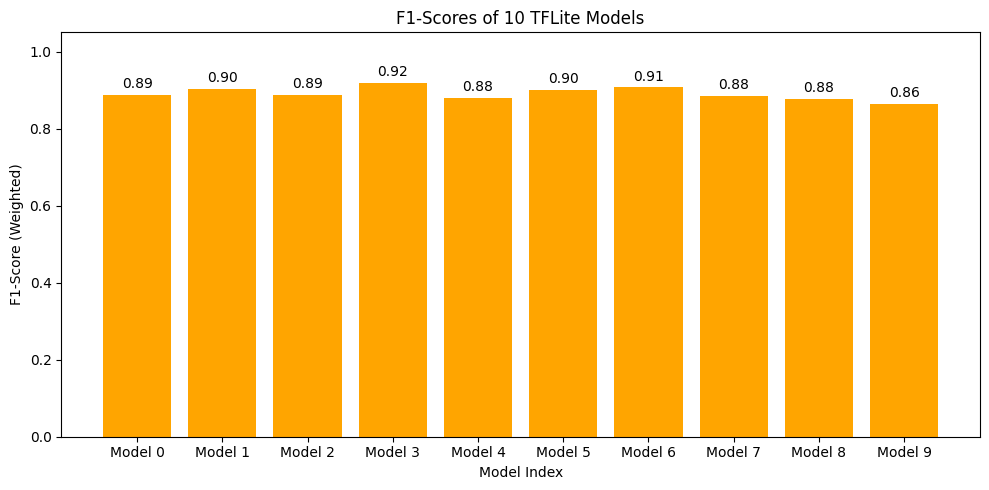

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score

# Paths to the 10 TFLite models
tflite_model_paths = [f"/mnt/c/modelFiles/10splitsFlatten/NoQuant_Attention_kfold_model_{fold}.tflite" for fold in range(10)]

# Load all interpreters
interpreters = []
input_details_list = []
output_details_list = []
quant_params_list = []

for path in tflite_model_paths:
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    scale, zero_point = input_details[0]['quantization']

    interpreters.append(interpreter)
    input_details_list.append(input_details)
    output_details_list.append(output_details)
    quant_params_list.append((scale, zero_point))

# Evaluate each model and store F1-scores
f1_scores = []

print(f"\nRunning evaluation for {len(interpreters)} individual TFLite models...\n")

for model_idx in range(len(interpreters)):
    y_true = []
    y_pred = []

    print(f"\n--- Evaluating TFLite Model {model_idx + 1} ---")

    for batch_images, batch_labels in test_generator:
        for img, label in zip(batch_images, batch_labels):
            img = np.expand_dims(img, axis=0).astype(np.float32)

            scale, zero_point = quant_params_list[model_idx]
            img_int8 = (img / scale + zero_point).astype(np.int8)

            interpreters[model_idx].set_tensor(input_details_list[model_idx][0]['index'], img_int8)
            interpreters[model_idx].invoke()
            output_data = interpreters[model_idx].get_tensor(output_details_list[model_idx][0]['index'])

            pred_class = np.argmax(output_data[0])
            true_class = np.argmax(label)

            y_pred.append(pred_class)
            y_true.append(true_class)

    f1 = f1_score(y_true, y_pred, average='weighted')
    f1_scores.append(f1)

    print(f"Model {model_idx + 1} Weighted F1-Score: {f1:.4f}")
    print("Classification Report:")
    target_names = list(label_encoder.classes_)  # assumes a fitted label_encoder
    print(classification_report(y_true, y_pred, target_names=target_names))

# --- Plot F1-Scores ---
plt.figure(figsize=(10, 5))
bars = plt.bar(range(10), f1_scores, color='orange')
plt.title('F1-Scores of 10 TFLite Models')
plt.xlabel('Model Index')
plt.ylabel('F1-Score (Weighted)')
plt.ylim(0, 1.05)
plt.xticks(range(10), [f'Model {i}' for i in range(10)])

# Annotate each bar with F1-score
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("tflite_f1_scores.png")
plt.show()


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X_train = all_filepaths
y_train = all_labels

def preprocess_image(path, label):
    img = load_img(path.decode(), target_size=IMG_SIZE, color_mode='grayscale')
    img = img_to_array(img) / 255.0
    return img, label

def tf_preprocess(path, label):
    img, lbl = tf.py_function(preprocess_image, [path, label], [tf.float32, tf.int64])
    img.set_shape((IMG_SIZE[0], IMG_SIZE[1], 1))
    lbl.set_shape(())
    return img, lbl

# Use full dataset for training
X_train = all_filepaths
y_train = all_labels

# Create the custom data generator using 100% of data
train_generator = CustomDataGenerator(
    image_paths=X_train,
    labels=y_train,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    num_classes=NUM_CLASSES,
    shuffle=True,
    class_indices=class_indices
)



In [26]:
model = create_cnn_model_with_attention(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:

train_generator = CustomDataGenerator(X_train_main, y_train_main, BATCH_SIZE, IMG_SIZE, NUM_CLASSES,class_indices=class_indices)
test_generator = CustomDataGenerator( X_test_final, y_test_final, BATCH_SIZE, IMG_SIZE, NUM_CLASSES, shuffle=False,class_indices=class_indices)
# %%

In [29]:
with tf.device('/GPU:0'):
        history = model.fit(
            train_generator,
            validation_data=test_generator,
            epochs=EPOCHS,
            callbacks=[early_stopping, lr_scheduler, ModelCheckpoint("/mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_Attention_kfold_model_final.keras", monitor='val_loss', save_best_only=True, verbose=1), stop_at_100],
            verbose=1
        )

converter = tf.lite.TFLiteConverter.from_keras_model(model)
print("converter set")
# Enable full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
print("optimizations initialized")
# Define a representative dataset function for calibration
def representative_dataset_gen():
    for i in range(100):  # Just use first 100 images for calibration
        img, _ = train_generator[i]
        for x in img:
            yield [np.expand_dims(x, axis=0).astype(np.float32)]


converter.representative_dataset = representative_dataset_gen
print("representative dataset initialized")
# Ensure all tensors are int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
print("type bit converstions done")
# Perform conversion
quantized_tflite_model = converter.convert()
print("quantized model obtained")
# Save the quantized model to disk
with open(f"/mnt/c/modelFiles/10splitsFlatten/tflite_NoQuant_Attention_final.tflite", "wb") as f:
    f.write(quantized_tflite_model)
print("tfmodel saved")

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.87885, saving model to /mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_Attention_kfold_model_final.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 49s 427ms/step - accuracy: 0.5833 - loss: 0.9772 - val_accuracy: 0.6250 - val_loss: 0.8788 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_loss improved from 0.87885 to 0.81305, saving model to /mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_Attention_kfold_model_final.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 47s 405ms/step - accuracy: 0.6610 - loss: 0.8186 - val_accuracy: 0.6542 - val_loss: 0.8130 - learning_rate: 0.0010
Epoch 3/100

Epoch 3: val_loss improved from 0.81305 to 0.61584, saving model to /mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_Attention_kfold_model_final.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 49s 431ms/step - accuracy: 0.7239 - loss: 0.7016 - val_accuracy: 0.7583 - val_loss: 0.6158 - learning_rate: 0.0010
Epoch 4/100

Epoch 4: val_loss improved from 0.61584 to 0.56376, saving

INFO:tensorflow:Assets written to: /tmp/tmp2ou8_c74/assets


Saved artifact at '/tmp/tmp2ou8_c74'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='keras_tensor_560')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139724212783248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139724214465744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139733892091728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725485163920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139724214465936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725700895888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725700893776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725689442512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725700892624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725689438480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1397254727

/home/srihari2895/TFProj/tfenv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1754589457.950930     406 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1754589457.951054     406 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-08-07 17:57:37.951770: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2ou8_c74
2025-08-07 17:57:37.952346: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-07 17:57:37.952356: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp2ou8_c74
2025-08-07 17:57:37.957911: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-07 17:57:38.000175: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /

quantized model obtained
tfmodel saved


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


**QUANTIZED MODEL EVALUATION**

.tflite Model


Running prediction using TFLite model...

TFLite Model Accuracy: 0.9208333333333333

Classification Report:
                 precision    recall  f1-score   support

      No_Defect       0.97      0.99      0.98        70
horizontal_line       0.86      0.88      0.87        34
          stain       1.00      1.00      1.00        32
           tear       0.90      0.92      0.91        71
  vertical_line       0.83      0.76      0.79        33

       accuracy                           0.92       240
      macro avg       0.91      0.91      0.91       240
   weighted avg       0.92      0.92      0.92       240



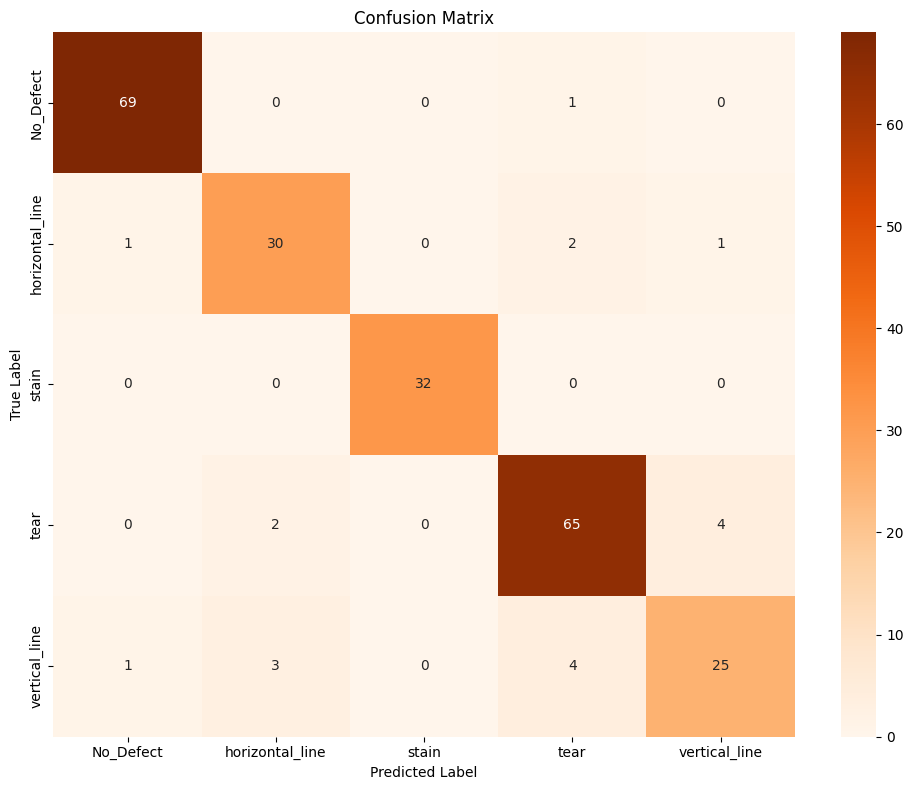

In [30]:

import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the TFLite model
model_path = "/mnt/c/modelFiles/10splitsFlatten/tflite_NoQuant_Attention_final.tflite" 

# Load interpreter
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
scale, zero_point = input_details[0]['quantization']

# Inference
y_true = []
y_pred = []

print("\nRunning prediction using TFLite model...\n")

for batch_images, batch_labels in test_generator:
    for img, label in zip(batch_images, batch_labels):
        img = np.expand_dims(img, axis=0).astype(np.float32)  # [1, H, W, C]

        img_int8 = (img / scale + zero_point).astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], img_int8)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])

        pred_class = np.argmax(output_data[0])
        true_class = np.argmax(label)

        y_pred.append(pred_class)
        y_true.append(true_class)

# Evaluation
print("TFLite Model Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))

# Classification report
target_names = list(label_encoder.classes_)  # assumes you have a fitted label_encoder
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


***KERAS MODEL EVALUATION***

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# Load one model 
model_path = "/mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_Attention_kfold_model_final.keras"
model = load_model(model_path)

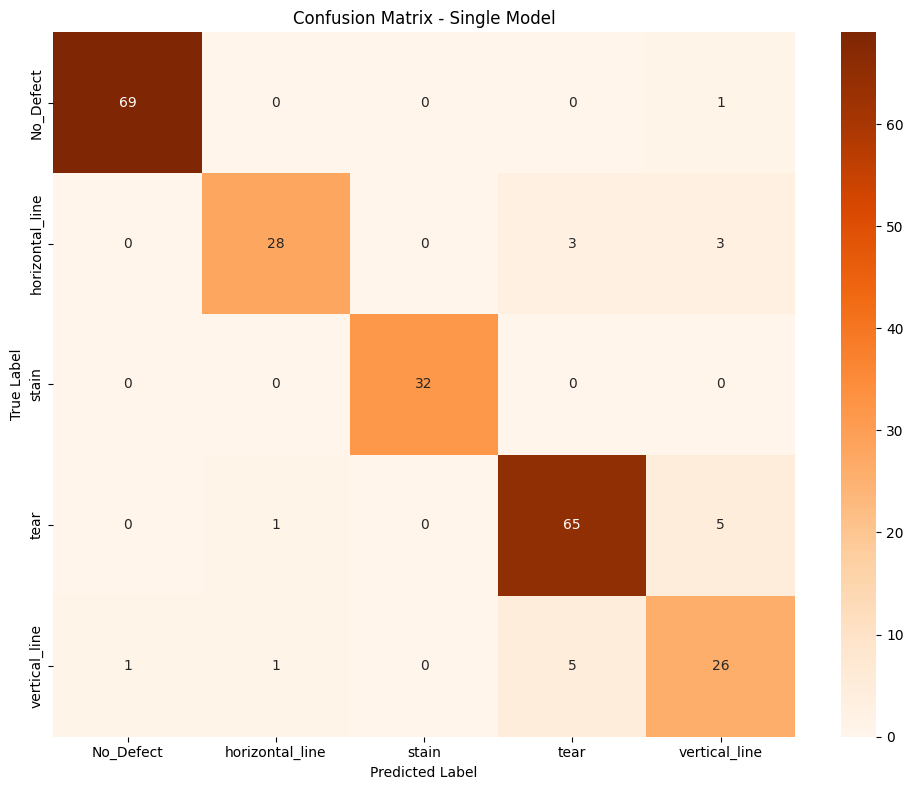


Classification Report:
                 precision    recall  f1-score   support

      No_Defect       0.99      0.99      0.99        70
horizontal_line       0.93      0.82      0.88        34
          stain       1.00      1.00      1.00        32
           tear       0.89      0.92      0.90        71
  vertical_line       0.74      0.79      0.76        33

       accuracy                           0.92       240
      macro avg       0.91      0.90      0.91       240
   weighted avg       0.92      0.92      0.92       240


Overall Accuracy: 0.9167

Per-class Accuracy:
No_Defect: 0.9857
horizontal_line: 0.8235
stain: 1.0000
tear: 0.9155
vertical_line: 0.7879


In [32]:
def evaluate_single_model(model, test_generator):
    num_samples = len(test_generator.image_paths)
    steps = int(np.ceil(num_samples / test_generator.batch_size))

    y_true_all, y_pred_all = [], []

    for _ in range(steps):
        x_batch, y_batch = next(test_generator)
        preds = model.predict(x_batch, verbose=0)
        y_pred_all.extend(np.argmax(preds, axis=1))
        y_true_all.extend(np.argmax(y_batch, axis=1))

    y_true_all = np.array(y_true_all[:num_samples])
    y_pred_all = np.array(y_pred_all[:num_samples])

    class_names = list(test_generator.class_indices.keys())

    # Confusion matrix
    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix - Single Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Metrics
    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all, target_names=class_names))

    accuracy = np.sum(y_true_all == y_pred_all) / len(y_true_all)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        mask = y_true_all == i
        correct = np.sum((y_true_all == i) & (y_pred_all == i))
        acc = correct / np.sum(mask) if np.sum(mask) > 0 else 0.0
        print(f"{class_name}: {acc:.4f}")

# Usage
evaluate_single_model(model, test_generator)


(SIMULATION) 
**COMPARISON BETWEEN A GENERIC MODEL AND QUANTIZATION AWARE TRAINING MODEL**

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load both models
model_path = "/mnt/c/modelFiles/10splitsFlatten/tflite_NoQuant_Attention_SP_model.tflite" 

original_model = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_kfold_model_4.keras")
quantized_model = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_quantized_kfold_model_0.keras", custom_objects=custom_objects)

# Build models if they aren't already
sample_input_shape = (None, 256, 256, 1)
original_model.build(input_shape=sample_input_shape)
quantized_model.build(input_shape=sample_input_shape)

# Extract weights for all convolutional layers
def get_all_conv_weights(model):
    weights = []
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, QuantizedConv2D)):
            w = layer.get_weights()
            if w:
                weights.append(w[0])  # Only use kernel weights
    return weights

orig_weights_list = get_all_conv_weights(original_model)
quant_weights_list = get_all_conv_weights(quantized_model)

# Sanity check
num_layers = min(len(orig_weights_list), len(quant_weights_list))
print(f"Comparing {num_layers} convolutional layers")

# Plot distributions for each layer
for i in range(num_layers):
    orig_weights = orig_weights_list[i].flatten()
    quant_weights = quant_weights_list[i].flatten()
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(orig_weights, bins=50, alpha=0.6, label='Original')
    plt.title(f'Layer {i+1} Original Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(quant_weights, bins=50, alpha=0.6, label='Quantized', color='orange')
    plt.title(f'Layer {i+1} Quantized Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(orig_weights, bins=50, alpha=0.5, label='Original')
    plt.hist(quant_weights, bins=50, alpha=0.5, label='Quantized')
    plt.title(f'Layer {i+1} Overlaid Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'conv_layer_{i+1}_weight_distribution_comparison.png')
    plt.show()


ValueError: File format not supported: filepath=/mnt/c/modelFiles/10splitsFlatten/tflite_NoQuant_Attention_SP_model.tflite. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/mnt/c/modelFiles/10splitsFlatten/tflite_NoQuant_Attention_SP_model.tflite, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

Comparing 3 Dense layers


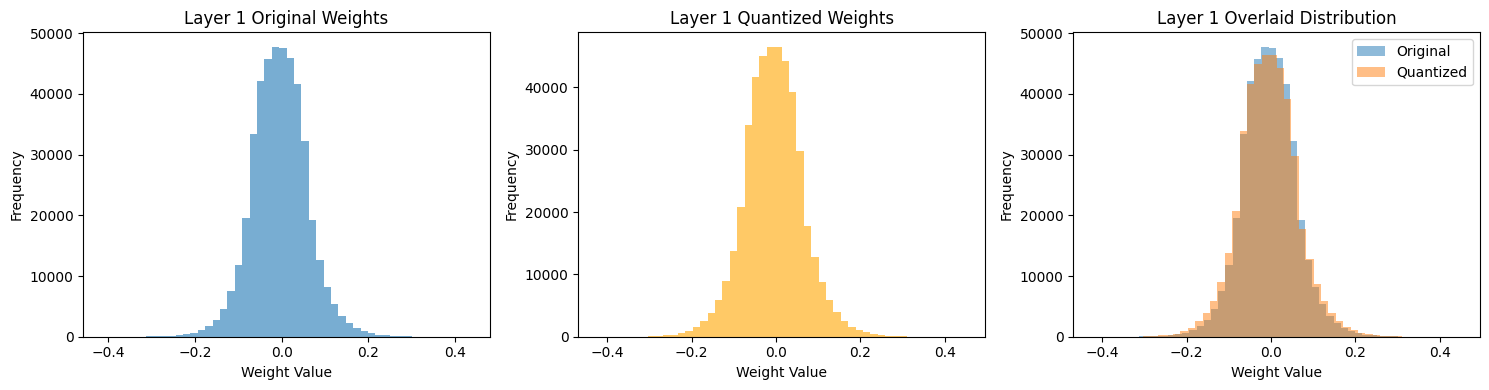

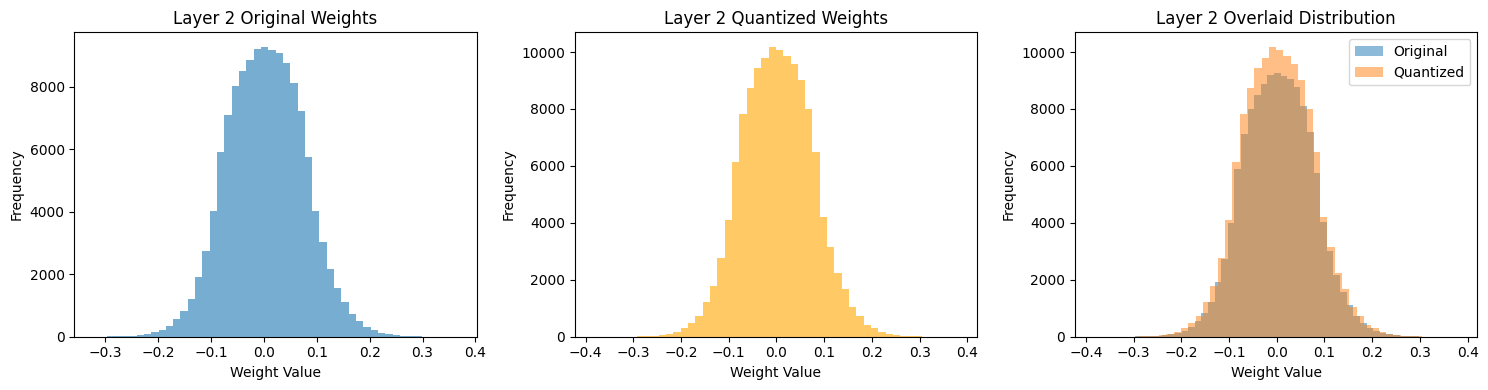

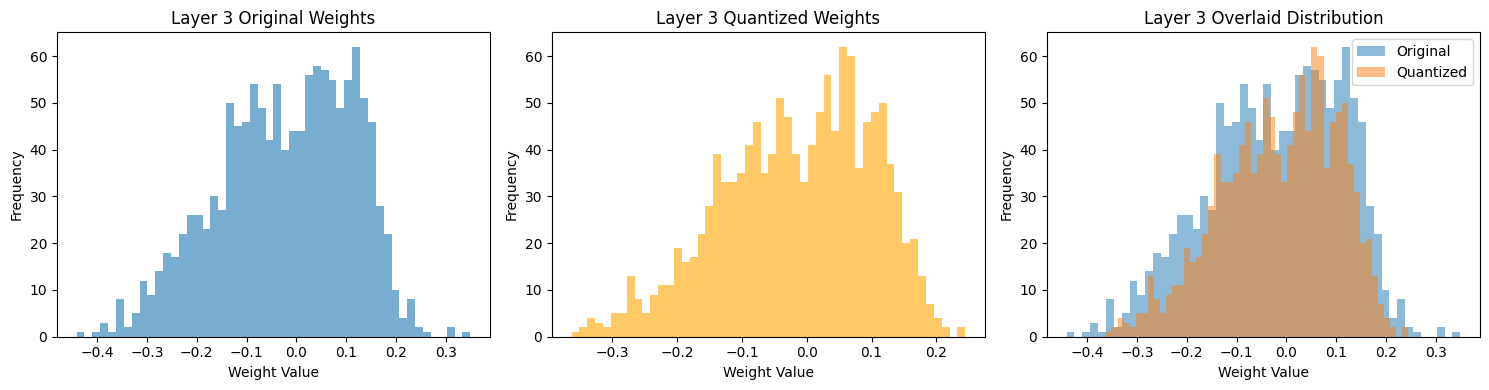

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load both models
original_model = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_kfold_model_4.keras")
quantized_model = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_quantized_kfold_model_0.keras", custom_objects=custom_objects)

# Build models if they aren't already
sample_input_shape = (None, 256, 256, 1)
original_model.build(input_shape=sample_input_shape)
quantized_model.build(input_shape=sample_input_shape)

# Extract weights for all convolutional layers
def get_all_conv_weights(model):
    weights = []
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Dense, QuantizedDense)):
            w = layer.get_weights()
            if w:
                weights.append(w[0])  # Only use kernel weights
    return weights

orig_weights_list = get_all_conv_weights(original_model)
quant_weights_list = get_all_conv_weights(quantized_model)

# Sanity check
num_layers = min(len(orig_weights_list), len(quant_weights_list))
print(f"Comparing {num_layers} Dense layers")

# Plot distributions for each layer
for i in range(num_layers):
    orig_weights = orig_weights_list[i].flatten()
    quant_weights = quant_weights_list[i].flatten()
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(orig_weights, bins=50, alpha=0.6, label='Original')
    plt.title(f'Layer {i+1} Original Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(quant_weights, bins=50, alpha=0.6, label='Quantized', color='orange')
    plt.title(f'Layer {i+1} Quantized Weights')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(orig_weights, bins=50, alpha=0.5, label='Original')
    plt.hist(quant_weights, bins=50, alpha=0.5, label='Quantized')
    plt.title(f'Layer {i+1} Overlaid Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'dense_layer_{i+1}_weight_distribution_comparison.png')
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


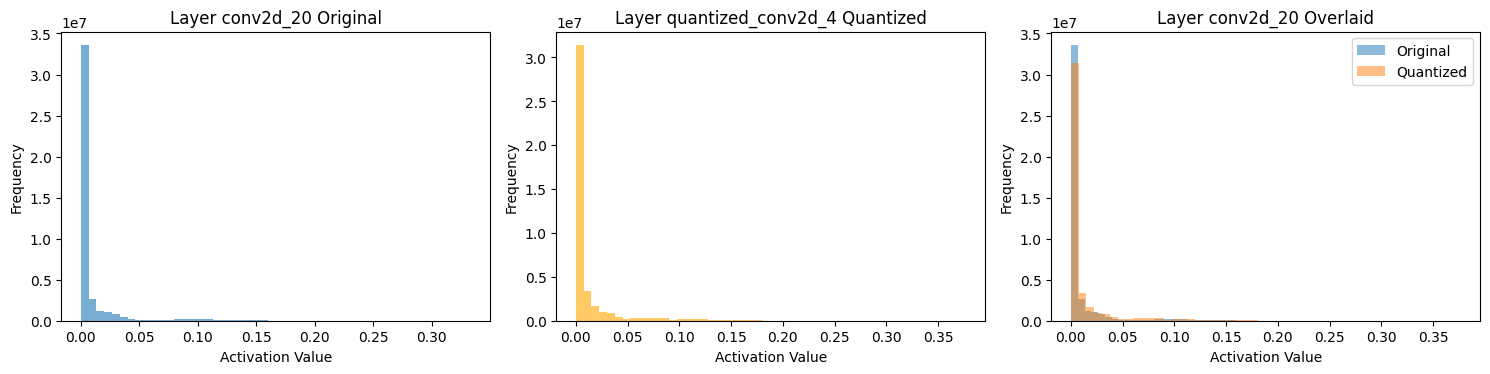

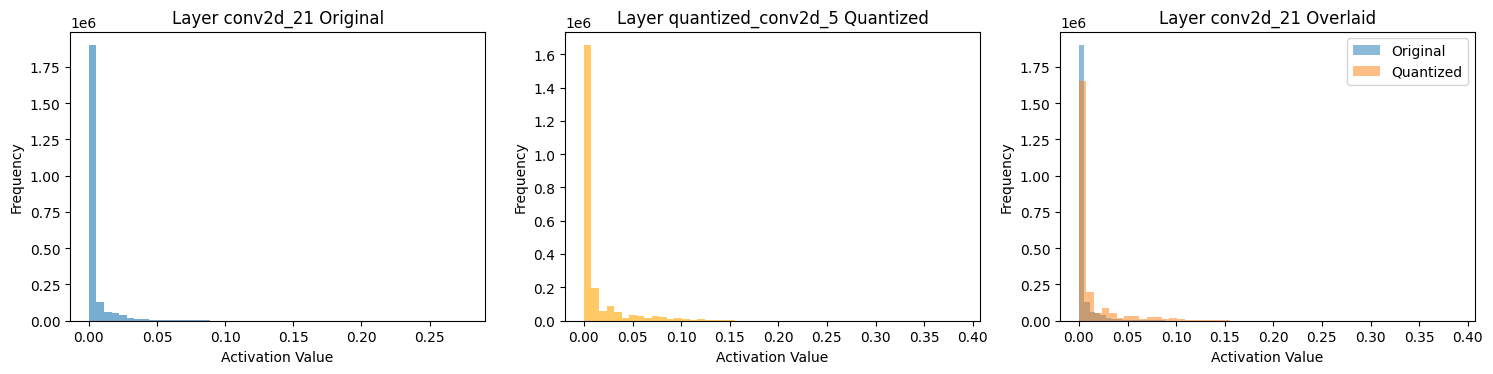

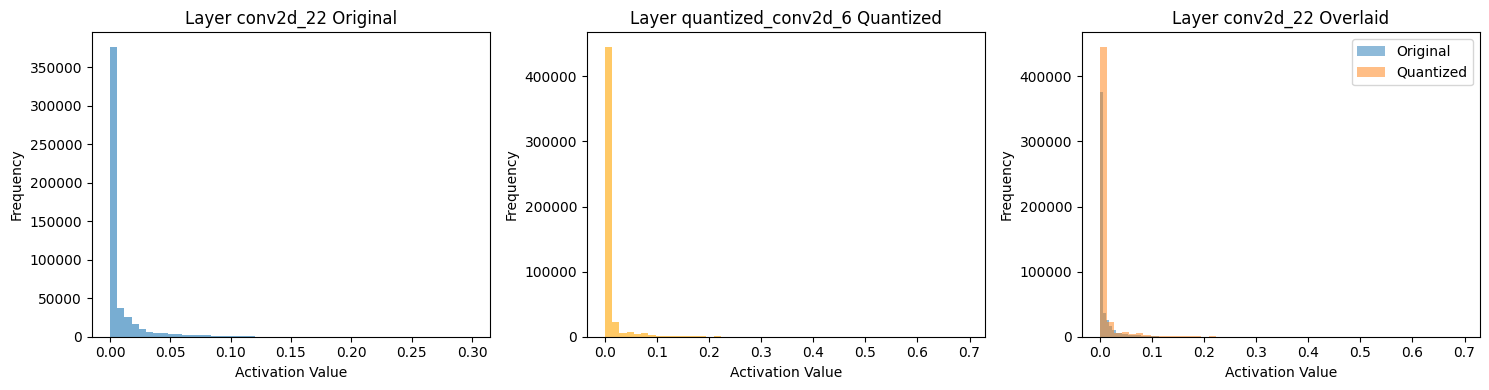

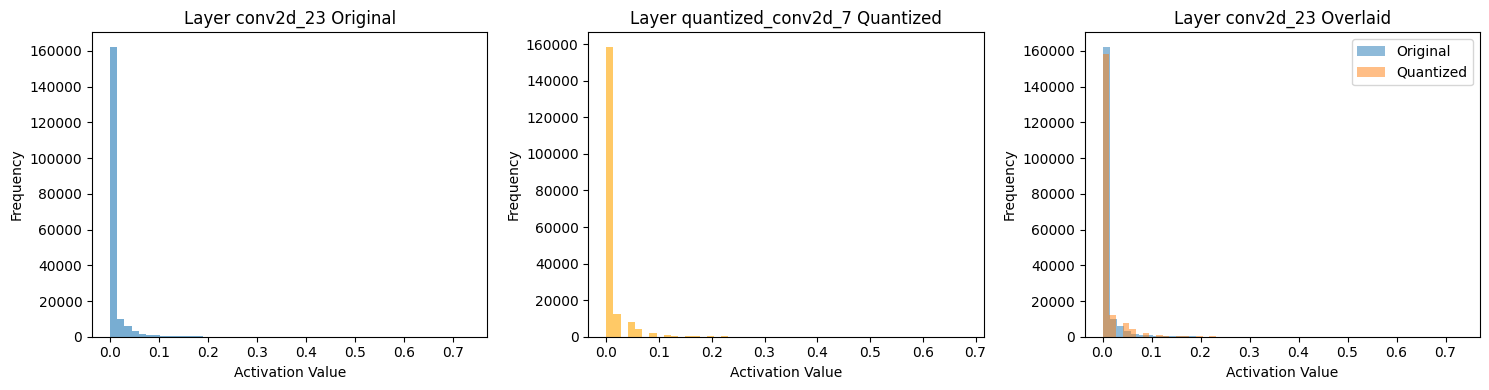

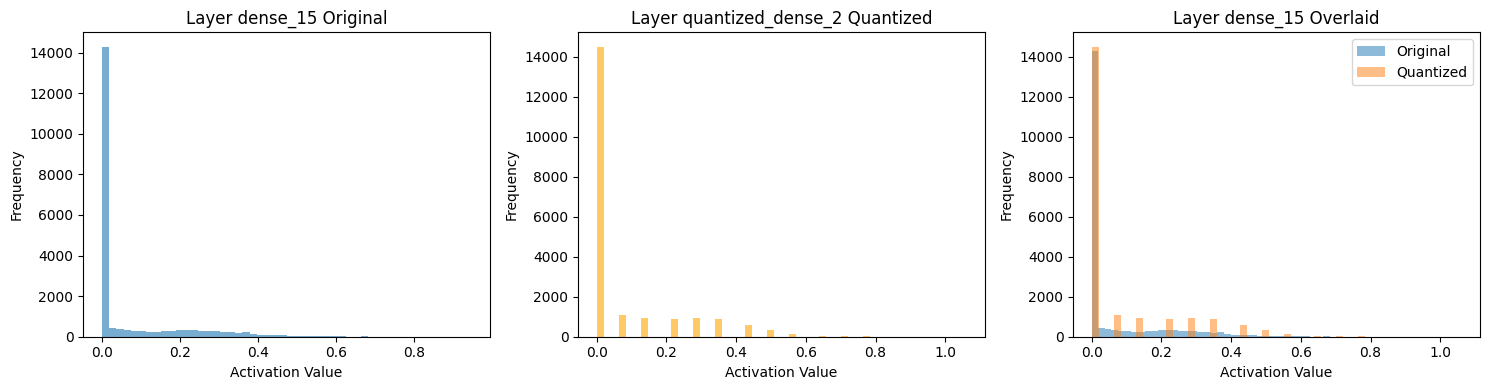

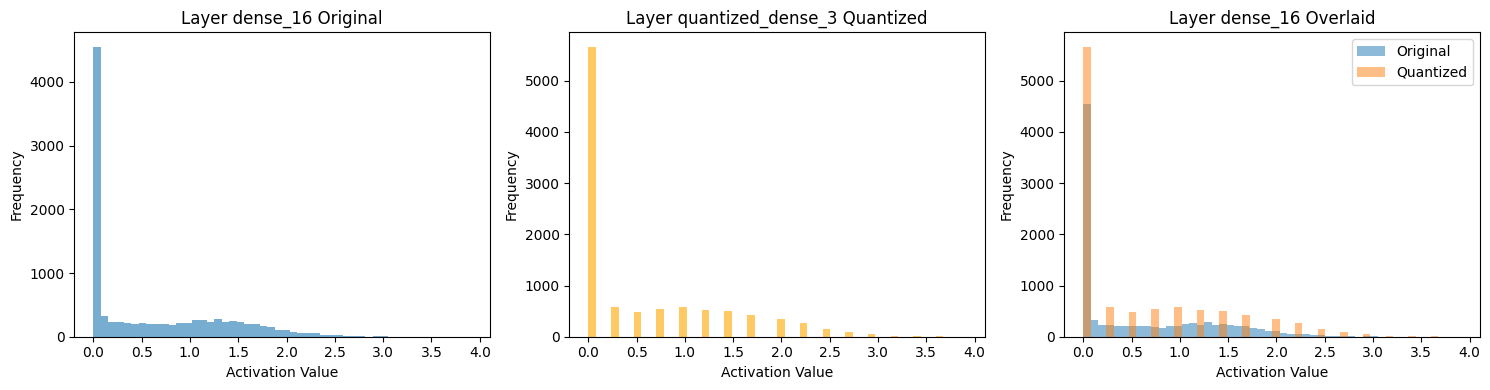

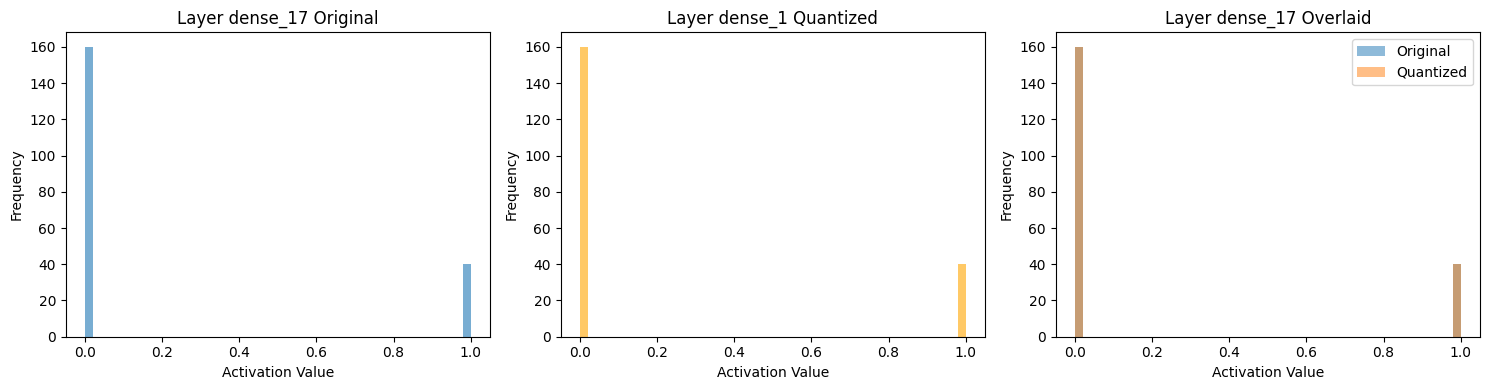

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Supported layer types for activation visualization
ACTIVATION_LAYERS = (tf.keras.layers.Conv2D, tf.keras.layers.Dense, QuantizedConv2D, QuantizedDense)

def create_activation_models(model):
    input_shape = (256, 256, 1)
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    outputs = []
    layer_names = []
    x = input_layer

    for layer in model.layers:
        try:
            x = layer(x)
            if isinstance(layer, ACTIVATION_LAYERS):
                outputs.append(x)
                layer_names.append(layer.name)
        except:
            continue
    
    activation_model = tf.keras.Model(inputs=input_layer, outputs=outputs)
    return activation_model, layer_names

# Create activation models
orig_activation_model, orig_layer_names = create_activation_models(original_model)
quant_activation_model, quant_layer_names = create_activation_models(quantized_model)

# Ensure layer alignment
num_layers = min(len(orig_layer_names), len(quant_layer_names))

# Get a batch of input
x_batch, _ = next(iter(test_generator))

# Predict activations
orig_activations = orig_activation_model.predict(x_batch)
quant_activations = quant_activation_model.predict(x_batch)

# Plot activation distributions for each layer
for i in range(num_layers):
    orig_act = orig_activations[i].flatten()
    quant_act = quant_activations[i].flatten()

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.hist(orig_act, bins=50, alpha=0.6, label='Original')
    plt.title(f'Layer {orig_layer_names[i]} Original')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(quant_act, bins=50, alpha=0.6, label='Quantized', color='orange')
    plt.title(f'Layer {quant_layer_names[i]} Quantized')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(orig_act, bins=50, alpha=0.5, label='Original')
    plt.hist(quant_act, bins=50, alpha=0.5, label='Quantized')
    plt.title(f'Layer {orig_layer_names[i]} Overlaid')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'activation_distribution_layer_{i+1}_{orig_layer_names[i]}.png')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict

original_model = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_kfold_model_4.keras")
quantized_model = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_quantized_kfold_model_0.keras", custom_objects=custom_objects)

# 1. Collect one image per class (assumes one-hot encoded labels)
def collect_one_sample_per_class(test_generator, num_classes=5):
    class_samples = {}
    for x_batch, y_batch in test_generator:
        for img, label in zip(x_batch, y_batch):
            class_idx = np.argmax(label)
            if class_idx not in class_samples:
                class_samples[class_idx] = img[np.newaxis, ...]  # Add batch dimension
            if len(class_samples) == num_classes:
                return class_samples
    return class_samples

# 2. Function to get intermediate layer outputs
def get_layer_outputs(model, input_data, num_layers=4):
    model.build(input_shape=(None, 256, 256, 1))
    outputs = []
    count = 0
    for layer in model.layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, QuantizedConv2D)):
            temp_model = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
            out = temp_model.predict(input_data)
            outputs.append(out)
            count += 1
            if count >= num_layers:
                break
    return outputs

# 3. Main logic
samples_per_class = collect_one_sample_per_class(test_generator, num_classes=5)

for class_idx, sample_img in samples_per_class.items():
    orig_features = get_layer_outputs(original_model, sample_img)
    quant_features = get_layer_outputs(quantized_model, sample_img)

    for layer_idx in range(min(len(orig_features), len(quant_features))):
        orig_feature = orig_features[layer_idx][0]   # Shape: (H, W, C)
        quant_feature = quant_features[layer_idx][0]

        # Compute average activation per channel
        orig_channel_strength = np.mean(orig_feature, axis=(0, 1))  # Shape: (C,)
        quant_channel_strength = np.mean(quant_feature, axis=(0, 1))  # Shape: (C,)

        # Get indices of top 8 channels
        top8_orig_indices = np.argsort(orig_channel_strength)[-8:][::-1]
        top8_quant_indices = np.argsort(quant_channel_strength)[-8:][::-1]

        plt.figure(figsize=(16, 8))
        plt.suptitle(f'Layer {layer_idx+1} Top-Activated Feature Maps', fontsize=16)

        for idx, (orig_ch, quant_ch) in enumerate(zip(top8_orig_indices, top8_quant_indices)):
            # Original model top channel
            plt.subplot(2, 8, idx + 1)
            plt.imshow(orig_feature[:, :, orig_ch], cmap='viridis')
            plt.title(f'Orig Ch {orig_ch}')
            plt.axis('off')

            # Quantized model top channel
            plt.subplot(2, 8, idx + 9)
            plt.imshow(quant_feature[:, :, quant_ch], cmap='viridis')
            plt.title(f'Quant Ch {quant_ch}')
            plt.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f'top_feature_map_layer_{layer_idx+1}_{class_idx+1}.png')
        plt.show()



In [ ]:
def visualize_quantization_effects(original_model_path, quantized_model_path, test_generator):
    """
    Visualize the effects of quantization on model weights and activations.
    
    Args:
        original_model_path: Path to the original (non-quantized) model
        quantized_model_path: Path to the quantized-aware trained model
        test_generator: A data generator providing test data
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import tensorflow as tf
    
    # Define custom objects for loading the quantized model
    custom_objects = {'QuantizedConv2D': QuantizedConv2D, 'QuantizedDense': QuantizedDense}
    
    # Load both models
    original_model = tf.keras.models.load_model(original_model_path)
    quantized_model = tf.keras.models.load_model(quantized_model_path, custom_objects=custom_objects)
    # Build models if they aren't already
    sample_input_shape = (None, 256, 256, 1)
    original_model.build(input_shape=sample_input_shape)
    quantized_model.build(input_shape=sample_input_shape)
    x_batch, _ = next(iter(test_generator))
    # Calculate size reduction
    def get_model_size(model):
        """Get approximate model size in MB"""
        weights = [w.numpy() for w in model.weights]
        total_params = sum(w.size for w in weights)
        
        # Calculate size in MB (32-bit float = 4 bytes)
        size_mb = (total_params * 4) / (1024 * 1024)
        return size_mb
    
    orig_size = get_model_size(original_model)
    
    # Simulate quantized model size (8-bit = 1 byte)
    quant_size = get_model_size(quantized_model) / 4  # Approximation: 8-bit is 1/4 of 32-bit
    
    print(f"Original model size: {orig_size:.2f} MB")
    print(f"Quantized model size: {quant_size:.2f} MB")
    print(f"Size reduction: {(1 - quant_size/orig_size) * 100:.1f}%")
    
    # Measure and compare inference speed
    import time
    
    # Warm up
    _ = original_model.predict(x_batch[:10])
    _ = quantized_model.predict(x_batch[:10])
    
    # Measure original model speed
    start_time = time.time()
    _ = original_model.predict(x_batch)
    orig_time = time.time() - start_time
    
    # Measure quantized model speed
    start_time = time.time()
    _ = quantized_model.predict(x_batch)
    quant_time = time.time() - start_time
    
    print(f"Original model inference time: {orig_time:.4f} seconds")
    print(f"Quantized model inference time: {quant_time:.4f} seconds")
    print(f"Speed improvement: {(1 - quant_time/orig_time) * 100:.1f}%")
    
    # Return summary as dictionary for further analysis
    return {
        "original_size_mb": orig_size,
        "quantized_size_mb": quant_size,
        "size_reduction_percent": (1 - quant_size/orig_size) * 100,
        "original_inference_time": orig_time,
        "quantized_inference_time": quant_time,
        "speed_improvement_percent": (1 - quant_time/orig_time) * 100
    }

visualize_quantization_effects("/mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_kfold_model_4.keras", "/mnt/c/modelFiles/10splitsFlatten/greyColor_quantized_kfold_model_0.keras", test_generator)

**CLASS BASED ADAPTIVE ACCURACY THRESHOLDING**

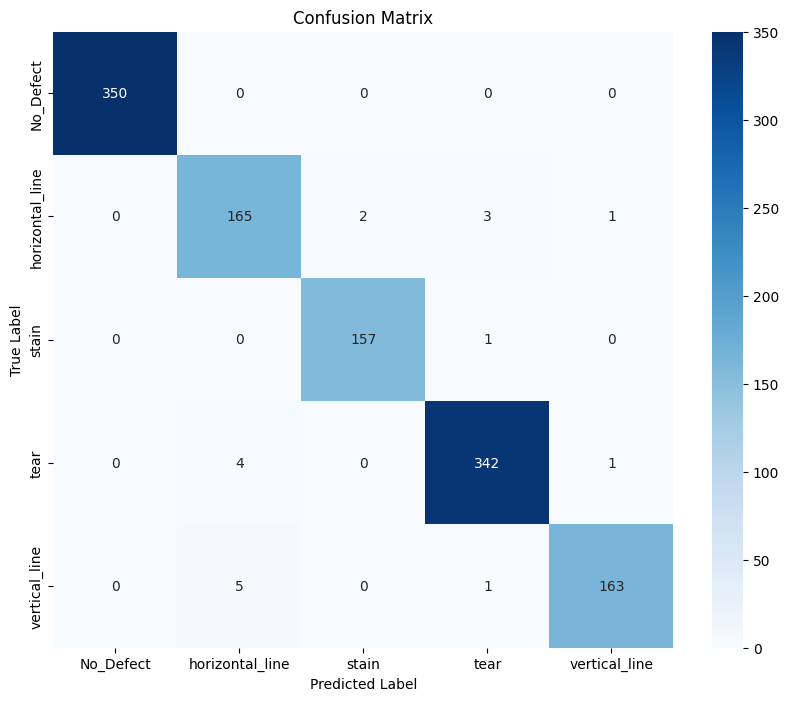

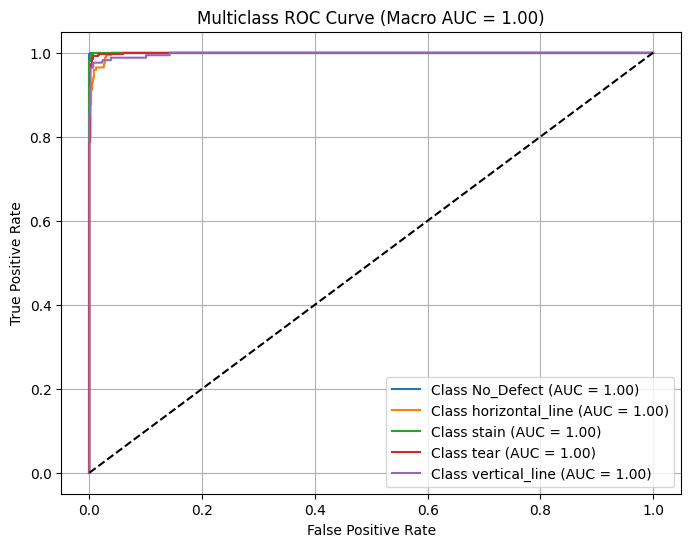


Classification Report:
                 precision    recall  f1-score   support

      No_Defect       1.00      1.00      1.00       350
horizontal_line       0.95      0.96      0.96       171
          stain       0.99      0.99      0.99       158
           tear       0.99      0.99      0.99       347
  vertical_line       0.99      0.96      0.98       169

       accuracy                           0.98      1195
      macro avg       0.98      0.98      0.98      1195
   weighted avg       0.99      0.98      0.98      1195


Optimal Per-Class Thresholds:
No_Defect: 0.31 (F1 = 1.0000)
horizontal_line: 0.37 (F1 = 0.9538)
stain: 0.19 (F1 = 0.9905)
tear: 0.26 (F1 = 0.9856)
vertical_line: 0.35 (F1 = 0.9760)

Overall Macro F1 Score: 0.9817
Macro-Averaged ROC AUC: 0.9991


In [99]:
#PER CLASS THRESHOLDING
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, auc
import tensorflow as tf

def calculate_metrics_multiclass(y_true, y_pred_probs, thresholds):
    """
    Apply per-class thresholds and compute evaluation metrics.
    
    Args:
        y_true: True class labels
        y_pred_probs: Predicted probabilities for each class
        thresholds: List of per-class thresholds
    
    Returns:
        y_pred: Final predicted labels based on adaptive thresholds
        cm: Confusion matrix
        f1_scores: Per-class F1 scores
    """
    num_samples, num_classes = y_pred_probs.shape
    y_pred = np.full(y_true.shape, -1)

    for idx in range(num_samples):
        valid_classes = []
        for i in range(num_classes):
            if y_pred_probs[idx, i] >= thresholds[i]:
                valid_classes.append(i)

        if valid_classes:
            # Among the valid classes, choose the one with the highest probability
            best_class = max(valid_classes, key=lambda i: y_pred_probs[idx, i])
            y_pred[idx] = best_class
        else:
            # Fallback to argmax if no class exceeds its threshold
            y_pred[idx] = np.argmax(y_pred_probs[idx])

    cm = confusion_matrix(y_true, y_pred)
    f1_scores = f1_score(y_true, y_pred, average=None)
    overall_f1 = f1_score(y_true, y_pred, average="macro")

    return y_pred, cm, f1_scores, overall_f1


def adaptive_threshold_determination_multiclass2(model, test_generator, threshold_range=None):
    """
    Determine adaptive per-class thresholds and evaluate the model.
    
    Args:
        model: Trained model
        test_generator: Test data generator
        threshold_range: Range of thresholds to test (default: 0 to 1 in 0.01 steps)
    
    Returns:
        optimal_thresholds: List of per-class optimal thresholds
    """
    # Reset generator and get predictions
    test_generator.reset()
    steps = len(test_generator)
    
    y_true = []
    y_pred_probs = []
    
    for _ in range(steps):
        x_batch, y_batch = next(test_generator)
        batch_pred = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot labels to indices
        y_pred_probs.extend(batch_pred)  # Store full probability distribution
    
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    num_classes = y_pred_probs.shape[1]
    class_names = list(test_generator.class_indices.keys())

    # Set threshold search range
    if threshold_range is None:
        threshold_range = np.arange(0, 1.01, 0.01)

    # Find best threshold for each class based on F1-score
    best_thresholds = []
    best_f1_scores = []

    for i in range(num_classes):
        best_threshold = 0.5  # Default
        best_f1 = 0.0

        for threshold in threshold_range:
            temp_thresholds = [0.5] * num_classes  # Start with default 0.5 for all
            temp_thresholds[i] = threshold  # Vary only the current class
            
            _, _, f1_scores, _ = calculate_metrics_multiclass(y_true, y_pred_probs, temp_thresholds)
            if f1_scores[i] > best_f1:
                best_f1 = f1_scores[i]
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        best_f1_scores.append(best_f1)

    # Apply optimal thresholds
    y_pred, cm, f1_scores, overall_f1 = calculate_metrics_multiclass(y_true, y_pred_probs, best_thresholds)

    # Compute ROC Curve & AUC per class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = y_pred_probs[:, i]

        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
        roc_auc[i] = auc(fpr[i], tpr[i])

    macro_auc = np.mean(list(roc_auc.values()))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve (Macro AUC = {macro_auc:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Print optimal thresholds
    print("\nOptimal Per-Class Thresholds:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {best_thresholds[i]:.2f} (F1 = {best_f1_scores[i]:.4f})")

    print(f"\nOverall Macro F1 Score: {overall_f1:.4f}")
    print(f"Macro-Averaged ROC AUC: {macro_auc:.4f}")

    return best_thresholds


# Usage:
def evaluate_multiclass_with_adaptive_threshold(model, test_generator):
    """
    Evaluate model on a multi-class dataset using adaptive thresholding.
    """
    optimal_thresholds = adaptive_threshold_determination_multiclass2(model, test_generator)
    return optimal_thresholds

cnn = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_quantized_kfold_model_0.keras")
try:
    evaluate_multiclass_with_adaptive_threshold(cnn,test_generator)
except StopIteration as e:
    print("iteration stopped. evaluating again.")
    evaluate_multiclass_with_adaptive_threshold(cnn,test_generator)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, auc
import tensorflow as tf

def run_tflite_inference(interpreter, input_data):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Quantization parameters for input
    input_index = input_details[0]['index']
    input_dtype = input_details[0]['dtype']
    input_scale, input_zero_point = input_details[0]['quantization']

    # Quantize input if needed
    if input_dtype == np.int8:
        input_data = input_data / input_scale + input_zero_point
        input_data = np.clip(np.round(input_data), -128, 127).astype(np.int8)
    elif input_dtype == np.uint8:
        input_data = input_data / input_scale + input_zero_point
        input_data = np.clip(np.round(input_data), 0, 255).astype(np.uint8)
    else:
        input_data = input_data.astype(input_dtype)

    interpreter.set_tensor(input_index, input_data)
    interpreter.invoke()

    # Dequantize output 
    output_index = output_details[0]['index']
    output_data = interpreter.get_tensor(output_index)

    output_dtype = output_details[0]['dtype']
    output_scale, output_zero_point = output_details[0]['quantization']

    if output_dtype == np.int8:
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale
    elif output_dtype == np.uint8:
        output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

    return output_data

import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

def calculate_metrics_multiclass(y_true, y_pred_probs, thresholds):
    num_samples, num_classes = y_pred_probs.shape
    y_pred = np.full(y_true.shape, -1)

    for idx in range(num_samples):
        valid_classes = []
        for i in range(num_classes):
            if y_pred_probs[idx, i] >= thresholds[i]:
                valid_classes.append(i)

        if valid_classes:
            # Among the valid classes, choose the one with the highest probability
            best_class = max(valid_classes, key=lambda i: y_pred_probs[idx, i])
            y_pred[idx] = best_class
        else:
            # Fallback to argmax if no class exceeds its threshold
            y_pred[idx] = np.argmax(y_pred_probs[idx])

    cm = confusion_matrix(y_true, y_pred)
    f1_scores = f1_score(y_true, y_pred, average=None)
    overall_f1 = f1_score(y_true, y_pred, average="macro")

    return y_pred, cm, f1_scores, overall_f1

def adaptive_threshold_determination_multiclass2_tflite(tflite_model_path, test_generator, threshold_range=None):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    steps = len(test_generator)
    y_true = []
    y_pred_probs = []

    for _ in range(steps):
        x_batch, y_batch = next(test_generator)
        batch_pred = []

        for i in range(x_batch.shape[0]):
            input_tensor = np.expand_dims(x_batch[i], axis=0).astype(np.float32)
            output = run_tflite_inference(interpreter, input_tensor)
            batch_pred.append(output[0])  

        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred_probs.extend(batch_pred)

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    num_classes = y_pred_probs.shape[1]
    class_names = list(test_generator.class_indices.keys())

    if threshold_range is None:
        threshold_range = np.arange(0, 1.01, 0.01)

    best_thresholds = []
    best_f1_scores = []

    for i in range(num_classes):
        best_threshold = 0.5
        best_f1 = 0.0

        for threshold in threshold_range:
            temp_thresholds = [0.5] * num_classes
            temp_thresholds[i] = threshold

            _, _, f1_scores, _ = calculate_metrics_multiclass(y_true, y_pred_probs, temp_thresholds)
            if f1_scores[i] > best_f1:
                best_f1 = f1_scores[i]
                best_threshold = threshold

        best_thresholds.append(best_threshold)
        best_f1_scores.append(best_f1)

    y_pred, cm, f1_scores, overall_f1 = calculate_metrics_multiclass(y_true, y_pred_probs, best_thresholds)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = y_pred_probs[:, i]

        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
        roc_auc[i] = auc(fpr[i], tpr[i])

    macro_auc = np.mean(list(roc_auc.values()))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve (Macro AUC = {macro_auc:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    print("\nOptimal Per-Class Thresholds:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {best_thresholds[i]:.2f} (F1 = {best_f1_scores[i]:.4f})")

    print(f"\nOverall Macro F1 Score: {overall_f1:.4f}")
    print(f"Macro-Averaged ROC AUC: {macro_auc:.4f}")

    return best_thresholds

def evaluate_multiclass_with_adaptive_threshold_tflite(tflite_model_path, test_generator):
    optimal_thresholds = adaptive_threshold_determination_multiclass2_tflite(tflite_model_path, test_generator)
    return optimal_thresholds


iteration stopped. evaluating again.


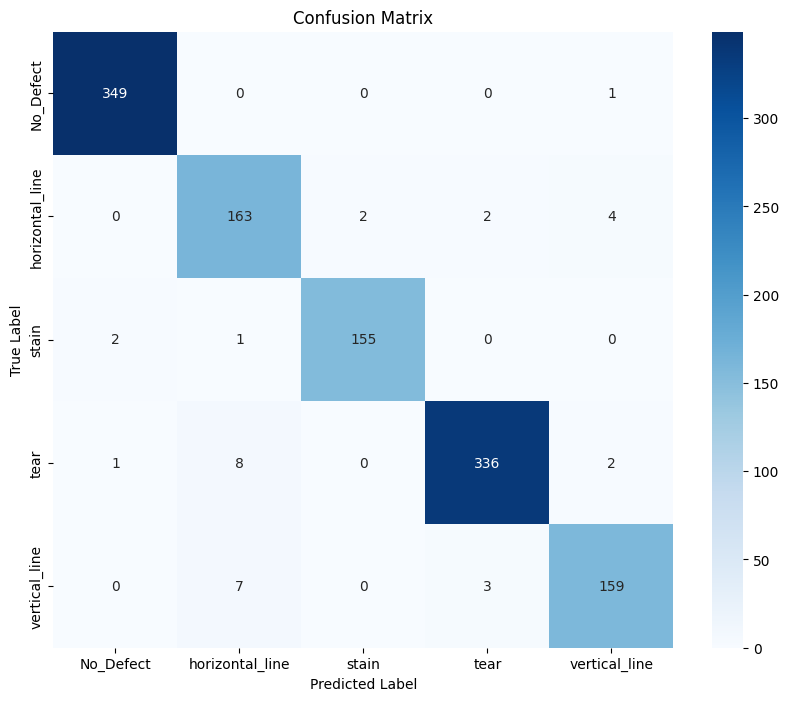

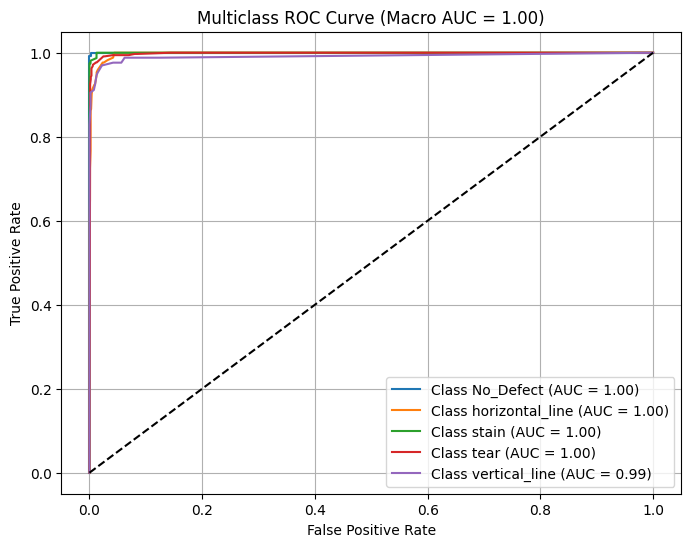


Classification Report:
                 precision    recall  f1-score   support

      No_Defect       0.99      1.00      0.99       350
horizontal_line       0.91      0.95      0.93       171
          stain       0.99      0.98      0.98       158
           tear       0.99      0.97      0.98       347
  vertical_line       0.96      0.94      0.95       169

       accuracy                           0.97      1195
      macro avg       0.97      0.97      0.97      1195
   weighted avg       0.97      0.97      0.97      1195


Optimal Per-Class Thresholds:
No_Defect: 0.51 (F1 = 0.9957)
horizontal_line: 0.50 (F1 = 0.9278)
stain: 0.25 (F1 = 0.9841)
tear: 0.48 (F1 = 0.9754)
vertical_line: 0.34 (F1 = 0.9493)

Overall Macro F1 Score: 0.9672
Macro-Averaged ROC AUC: 0.9975


In [89]:
try:
    optimal_thresholds = evaluate_multiclass_with_adaptive_threshold_tflite("/mnt/c/modelFiles/10splitsFlatten/quantized_kfold_model_0.tflite" , test_generator)
except StopIteration as e:
    print("iteration stopped. evaluating again.")
    optimal_thresholds = evaluate_multiclass_with_adaptive_threshold_tflite("/mnt/c/modelFiles/10splitsFlatten/quantized_kfold_model_0.tflite" , test_generator)

***QAT GENERIC KERAS MODEL RESOURCE UTILISATIONS AND INFERENCE***

In [28]:

import time
import psutil
import GPUtil
import pynvml
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.compat.v1.profiler import profile
from tensorflow.compat.v1.profiler import ProfileOptionBuilder
import keras

#best model
model=keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_quantized_kfold_model_0.keras")

# Load a single test image
img_path = "/mnt/c/newTrain/Train/line/17.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = img.astype(np.float32) / 255.0

# Stack into 1 channel
stacked = np.stack([img], axis=-1)  # shape: (256, 256, 1)
img_array = np.expand_dims(stacked, axis=0)  # shape: (1, 256, 256, 1)

# Cold start timing
t1 = time.time()
ensemble_probs = model.predict(img_array, verbose=0)
t2 = time.time()
cold_start_time = t2 - t1

# Inference timing
num_trials = 10
times = []
for _ in range(num_trials):
    t1 = time.time()
    _ = model.predict(img_array, verbose=0)
    t2 = time.time()
    times.append(t2 - t1)
inference_time = np.mean(times)

def get_model_size(model):
        """Get approximate model size in MB"""
        weights = [w.numpy() for w in model.weights]
        total_params = sum(w.size for w in weights)
        
        # Calculate size in MB (32-bit float = 4 bytes)
        size_mb = (total_params * 4) / (1024 * 1024)
        return size_mb
# model size
model_size = get_model_size(model)

# Memory usage
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 * 1024)
_ = np.mean([model.predict(img_array, verbose=0)], axis=0)
mem_after = process.memory_info().rss / (1024 * 1024)
memory_usage = mem_after - mem_before

# GPU and CPU stats
gpus = GPUtil.getGPUs()
gpu_usage = gpus[0].load * 100 if gpus else None
cpu_util = psutil.cpu_percent(interval=1)

# Power usage (CPU only)
try:
    power_usage = psutil.sensors_battery().power_plugged
except AttributeError:
    power_usage = None

# GPU power usage
def get_gpu_power():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    power = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000
    pynvml.nvmlShutdown()
    return power
power_watts = get_gpu_power()

# FLOPs
import io
from contextlib import redirect_stdout

def get_flops(model, input_shape):
    concrete = tf.function(lambda inputs: model(inputs)).get_concrete_function(
        tf.TensorSpec([1] + list(input_shape), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete)
    graph = frozen_func.graph

    run_meta = tf.compat.v1.RunMetadata()
    opts = ProfileOptionBuilder.float_operation()

    # Suppress stdout
    with io.StringIO() as buf, redirect_stdout(buf):
        flops = profile(graph, run_meta=run_meta, options=opts)
    
    return flops.total_float_ops

input_shape = (256, 256, 1)
flops = get_flops(models[0], input_shape) * len(models)  # total ensemble FLOPs

# Parameter count
num_params = model.count_params()

# Data load timing
t1 = time.time()
_ = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
t2 = time.time()
data_loading_time = t2 - t1

# Sparsity
def get_sparsity_ratio(model):
    total_params = np.sum([np.prod(w.shape) for w in model.weights])
    zero_params = np.sum([np.sum(w.numpy() == 0) for w in model.weights])
    return zero_params / total_params

avg_sparsity= get_sparsity_ratio(model)


# Energy efficiency
def get_energy_efficiency(flops, power_watts=None):
    if power_watts is None:
        return "Power consumption data missing"
    return flops / power_watts

energy_efficiency = get_energy_efficiency(flops, power_watts)

# results
print(f"Cold Start Time: {cold_start_time:.4f} seconds")
print(f"Average Inference Time: {inference_time:.4f} seconds")
print(f"Model Size: {model_size:.2f} MB")
print(f"Memory Usage: {memory_usage:.2f} MB")
print(f"Total FLOPs (Ensemble): {flops}")
print(f"Total Parameters (Ensemble): {num_params}")
print(f"GPU Utilization: {gpu_usage:.2f}%" if gpu_usage is not None else "GPU Utilization: Not Available")
print(f"CPU Utilization: {cpu_util:.2f}%")
print(f"Power Consumption (CPU): {power_usage}")
print(f"Power Watts (GPU): {power_watts}")
print(f"Data Loading Time: {data_loading_time:.4f} seconds")
print(f"Sparsity Ratio: {avg_sparsity:.4f}")
print(f"Energy Efficiency (FLOPs/Watt): {energy_efficiency}")


I0000 00:00:1746783160.678142  261896 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1746783160.678308  261896 single_machine.cc:361] Starting new session
I0000 00:00:1746783160.678868  261896 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

***QUANTIZED TFLITE MODEL RESOURCE UTILISATIONS AND INFERENCE***

In [25]:

import time
import psutil
import GPUtil
import pynvml



model_paths = [
   f"/mnt/c/modelFiles/10splitsFlatten/quantized_kfold_model_{i}.tflite" for i in range(10) 
]

# Load interpreters
interpreters = [tf.lite.Interpreter(model_path=path) for path in model_paths]
for interpreter in interpreters:
    interpreter.allocate_tensors()
    
#using first model
input_details = interpreters[0].get_input_details() 
output_details = interpreters[0].get_output_details()

# Preprocess image
img_path = "/mnt/c/newTrain/Train/line/17.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = img.astype(np.float32) / 255.0

# Stack channels
stacked = np.stack([img], axis=-1)

# Quantize input
input_scale, input_zero_point = input_details[0]['quantization']
img_input = stacked / input_scale + input_zero_point
img_input = np.clip(img_input, -128, 127).astype(np.int8)
img_input = np.expand_dims(img_input, axis=0)

# Cold start time (for one model)
t1 = time.time()
interpreters[0].set_tensor(input_details[0]['index'], img_input)
interpreters[0].invoke()
_ = interpreters[0].get_tensor(output_details[0]['index'])
t2 = time.time()
cold_start_time = t2 - t1

# Inference time over 10 trials (ensemble)
times = []
for _ in range(10):
    t1 = time.time()
    predictions = []
    for interpreter in interpreters:
        interpreter.set_tensor(input_details[0]['index'], img_input)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0])
    _ = np.mean(predictions, axis=0)
    t2 = time.time()
    times.append(t2 - t1)
inference_time = np.mean(times)

# Model size of tflite model 
model_size = os.path.getsize("/mnt/c/modelFiles/10splitsFlatten/quantized_kfold_model_0.tflite") / (1024 * 1024)

# Memory usage
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024 * 1024)
for interpreter in interpreters:
    interpreter.set_tensor(input_details[0]['index'], img_input)
    interpreter.invoke()
    _ = interpreter.get_tensor(output_details[0]['index'])
mem_after = process.memory_info().rss / (1024 * 1024)
memory_usage = mem_after - mem_before

# GPU usage
gpus = GPUtil.getGPUs()
gpu_usage = gpus[0].load * 100 if gpus else None

# CPU usage
cpu_util = psutil.cpu_percent(interval=1)

# Power (battery)
try:
    power_usage = psutil.sensors_battery().power_plugged
except:
    power_usage = None

# GPU power
def get_gpu_power():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    power = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000
    pynvml.nvmlShutdown()
    return power

power_watts = get_gpu_power()

# Data loading time
t1 = time.time()
_ = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
t2 = time.time()
data_loading_time = t2 - t1

# Print results
print(f"Cold Start Time: {cold_start_time:.4f} s")
print(f"Average Inference Time: {inference_time:.4f} s")
print(f"average Model Size: {model_size:.2f} MB")
print(f"Memory Usage: {memory_usage:.2f} MB")
print(f"GPU Utilization: {gpu_usage:.2f}%" if gpu_usage else "GPU Utilization: Not Available")
print(f"CPU Utilization: {cpu_util:.2f}%")
print(f"Power Plugged In: {power_usage}")
print(f"GPU Power (W): {power_watts}")
print(f"Data Loading Time: {data_loading_time:.4f} s")


Cold Start Time: 0.0186 s
Average Inference Time: 0.0740 s
average Model Size: 0.67 MB
Memory Usage: 0.00 MB
GPU Utilization: Not Available
CPU Utilization: 0.50%
Power Plugged In: True
GPU Power (W): 4.867
Data Loading Time: 0.0206 s


**ENDING CODES**

In [ ]:
!pip freeze > req.txt

56423.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


New results 1

In [15]:
X_test, y_test = [], []
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    X_test.append(x_batch)
    y_test.append(y_batch)

X_test = np.vstack(X_test)
y_test = np.vstack(y_test)

# Print shape info
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (1195, 256, 256, 1)
y_test shape: (1195, 5)


In [16]:
from sklearn.preprocessing import label_binarize
y_test = label_binarize(y_test, classes=range(test_generator.num_classes))


In [17]:
model1 = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_Nokfold_model.keras")
model2 = tf.keras.models.load_model("/mnt/c/modelFiles/10splitsFlatten/greyColor_NoQuant_kfold_model_4.keras")

In [18]:
y_score = model2.predict(X_test)
print(np.min(y_score), np.max(y_score))
print("Sample predictions:", y_score[:5])


I0000 00:00:1752074907.907570    2087 service.cc:148] XLA service 0x7f1e9c004100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752074907.907952    2087 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-07-09 15:28:27.919350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752074908.000366    2087 cuda_dnn.cc:529] Loaded cuDNN version 90300


32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

I0000 00:00:1752074910.586910    2087 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step
0.0 1.0
Sample predictions: [[9.9994671e-01 3.5522077e-10 1.6474821e-16 2.2991212e-08 5.3228607e-05]
 [1.0000000e+00 1.3731415e-10 3.0250848e-19 6.4692231e-11 3.7052381e-08]
 [9.9999988e-01 5.9132410e-09 4.5848845e-17 7.9366927e-08 5.4090976e-10]
 [9.9999297e-01 4.0227178e-06 4.8582145e-13 3.0118422e-06 2.8958260e-09]
 [9.9999905e-01 5.7292069e-09 3.9567780e-15 2.7383069e-07 7.2705689e-07]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


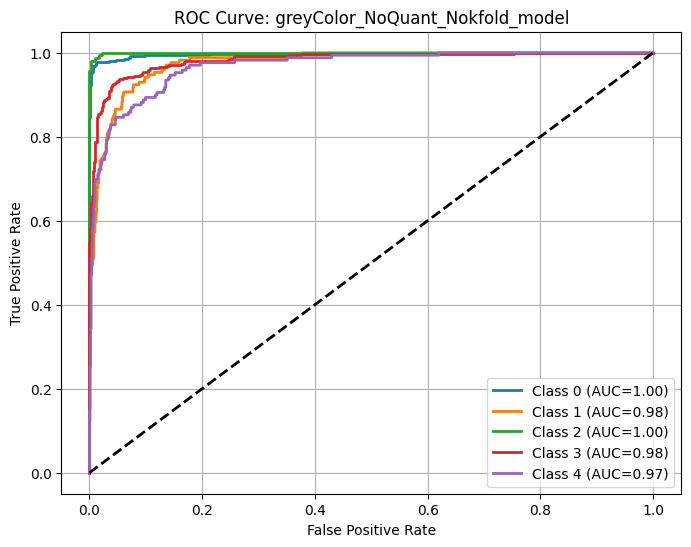

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


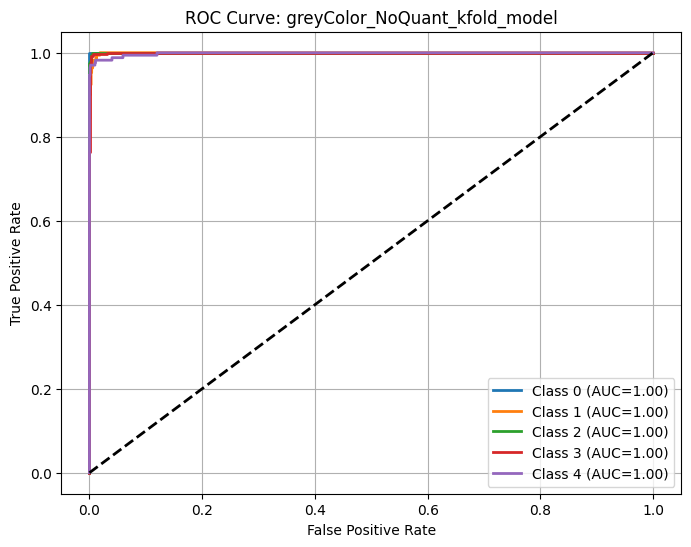

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc_robust(model, X_test, y_test, model_name="Model"):
    y_score = model.predict(X_test)
    n_classes = y_test.shape[1]

    plt.figure(figsize=(8, 6))
    valid = False
    for i in range(n_classes):
        if np.sum(y_test[:, i]) == 0 or np.sum(y_test[:, i]) == len(y_test):
            print(f"Skipping Class {i} — only one class present in ground truth.")
            continue
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        if np.isnan(roc_auc): continue
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc:.2f})')
        valid = True

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    if valid:
        plt.legend(loc='lower right')
    else:
        plt.text(0.3, 0.5, "ROC could not be computed for any class", fontsize=12)
    plt.grid(True)
    plt.show()

plot_roc_auc_robust(model1, X_test, y_test, model_name="greyColor_NoQuant_Nokfold_model")
plot_roc_auc_robust(model2, X_test, y_test, model_name="greyColor_NoQuant_kfold_model")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


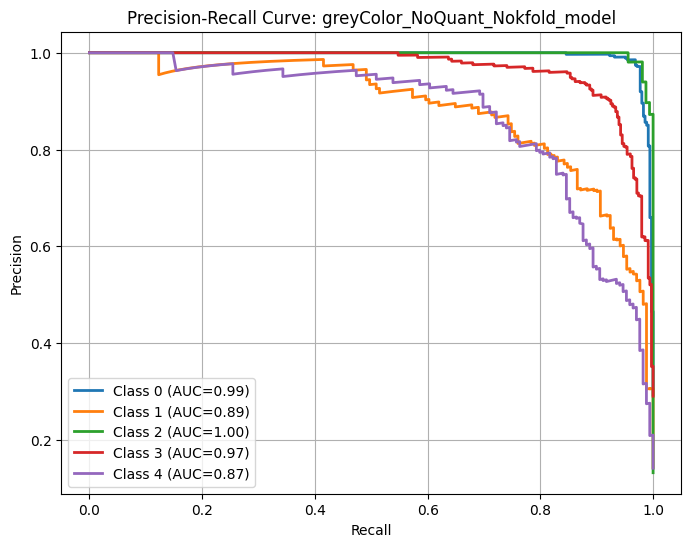

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


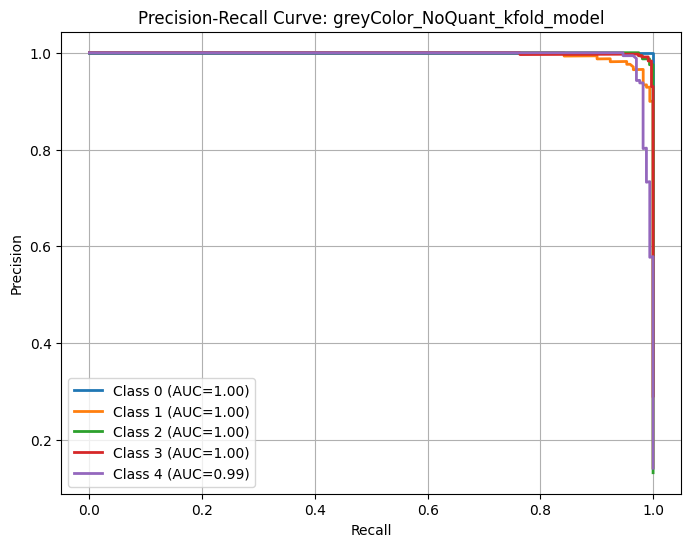

In [20]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_pr_auc(model, X_test, y_test, model_name="Model"):
    y_score = model.predict(X_test)
    n_classes = y_test.shape[1]

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'Class {i} (AUC={pr_auc:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {model_name}")
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Example usage
plot_pr_auc(model1, X_test, y_test, "greyColor_NoQuant_Nokfold_model")
plot_pr_auc(model2, X_test, y_test, "greyColor_NoQuant_kfold_model")


In [21]:
from sklearn.metrics import log_loss

def compute_log_loss(model, X_test, y_test, model_name="Model"):
    y_prob = model.predict(X_test)
    loss = log_loss(y_test, y_prob)
    print(f"{model_name} Log Loss: {loss:.4f}")

# Example usage
compute_log_loss(model1, X_test, y_test, "Model 1")
compute_log_loss(model2, X_test, y_test, "Model 2")


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model 1 Log Loss: 0.3091
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Model 2 Log Loss: 0.0460


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


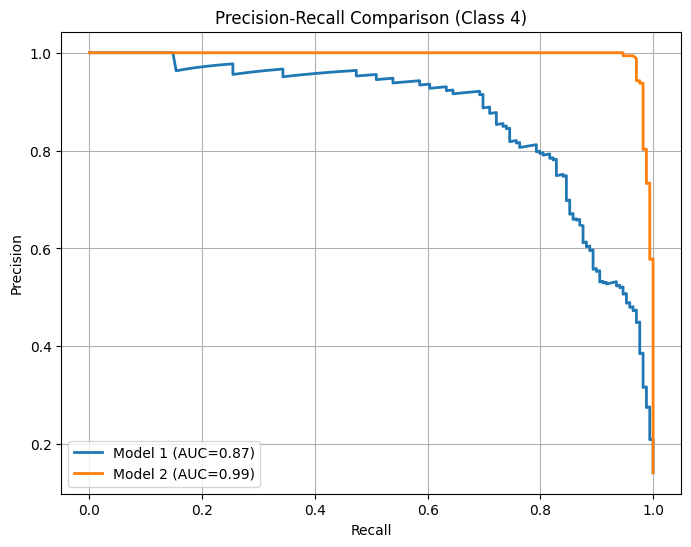

In [22]:
def compare_pr_curves(models, model_names, X_test, y_test, class_index=0):
    plt.figure(figsize=(8, 6))
    for model, name in zip(models, model_names):
        y_score = model.predict(X_test)
        precision, recall, _ = precision_recall_curve(y_test[:, class_index], y_score[:, class_index])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'{name} (AUC={pr_auc:.2f})')
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Comparison (Class {class_index})")
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Example usage for class 0
compare_pr_curves(
    [model1, model2],
    ["Model 1", "Model 2"],
    X_test, y_test,
    class_index=4
)


In [37]:
def grad_cam(model, image, class_idx, conv_layer_name=None):
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2

    # Force graph initialization
    _ = model(np.expand_dims(image, axis=0), training=False)

    # Automatically find last Conv2D layer if not given
    if conv_layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                conv_layer_name = layer.name
                break

    conv_layer = model.get_layer(conv_layer_name)

    # Build grad model
    grad_model = tf.keras.models.Model(
        [model.input], [conv_layer.output, model.output]
    )

    # Gradient calculation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-6)
    heatmap = heatmap.numpy()

    # Resize & colorize
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Normalize input image for overlay
    if np.max(image) <= 1.0:
        image_disp = np.uint8(image * 255)
    else:
        image_disp = np.uint8(image)

    if image_disp.shape[-1] == 1:
        image_disp = np.repeat(image_disp, 3, axis=-1)

    superimposed = heatmap_color * 0.4 + image_disp

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_disp.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed.astype("uint8"))
    plt.title(f"Grad-CAM (Class {class_idx})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


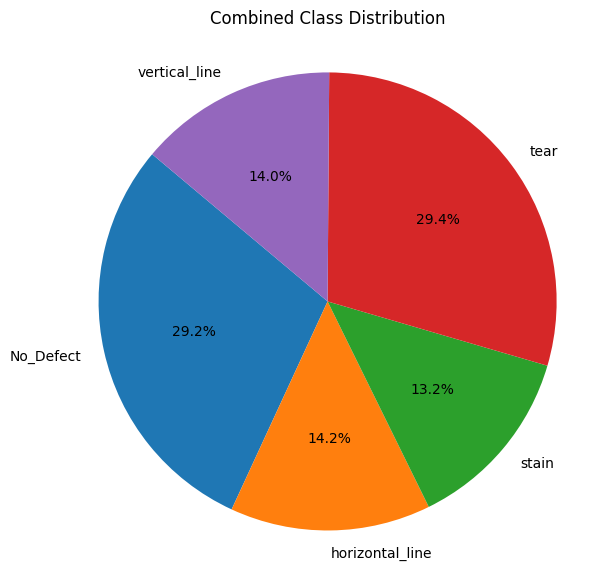

Class distribution: {'No_Defect': 1403, 'horizontal_line': 680, 'stain': 633, 'tear': 1412, 'vertical_line': 672}


In [23]:
import os
from collections import Counter
import matplotlib.pyplot as plt

def count_images_in_class_dirs(base_dir):
    class_counts = Counter()
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[class_name] += num_images
    return class_counts

# Count images from both folders
train_counts = count_images_in_class_dirs(train_dir)
test_counts = count_images_in_class_dirs(test_dir)

# Combine counts
total_counts = train_counts + test_counts

# Sort by class name (optional for neat pie chart)
total_counts = dict(sorted(total_counts.items()))

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(total_counts.values(), labels=total_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Combined Class Distribution")
plt.axis('equal')
plt.tight_layout()
plt.show()
print("Class distribution:", total_counts)



38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


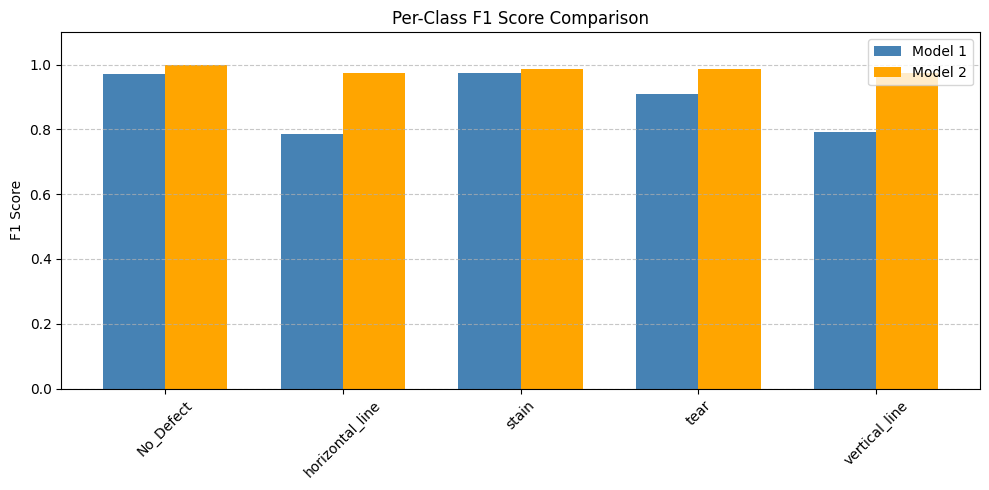

In [25]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predictions from both models
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)

# Step 2: Convert to class labels
y_pred1_labels = np.argmax(y_pred1, axis=1)
y_pred2_labels = np.argmax(y_pred2, axis=1)
y_true_labels = np.argmax(y_test, axis=1)  # assumes one-hot y_test

# Step 3: Get per-class F1 scores
report1 = classification_report(y_true_labels, y_pred1_labels, output_dict=True, zero_division=0)
report2 = classification_report(y_true_labels, y_pred2_labels, output_dict=True, zero_division=0)

# Step 4: Extract per-class F1 scores
class_labels = sorted([int(k) for k in report1.keys() if k.isdigit()])
f1_scores_1 = [report1[str(cls)]['f1-score'] for cls in class_labels]
f1_scores_2 = [report2[str(cls)]['f1-score'] for cls in class_labels]

# Optional: add class names
class_names = ['No_Defect', 'horizontal_line', 'stain', 'tear', 'vertical_line']

# Step 5: Plotting
x = np.arange(len(class_labels))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, f1_scores_1, width, label='Model 1', color='steelblue')
plt.bar(x + width/2, f1_scores_2, width, label='Model 2', color='orange')

plt.xticks(x, class_names, rotation=45)
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Score Comparison')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Jetson nano inference

In [ ]:
import time, os, psutil
import numpy as np
import tflite_runtime.interpreter as tflite
import pynvml  # NVIDIA GPU usage

# -----------------------
# Config
# -----------------------
MODEL_PATH = "model.tflite"
NUM_RUNS = 50  # number of inferences to average

# Load model size
model_size_mb = os.path.getsize(MODEL_PATH) / (1024 * 1024)

# Initialize interpreter
interpreter = tflite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Example dummy input (replace with your real preprocessed image)
input_data = np.random.randint(0, 255, size=(1, 256, 256, 1), dtype=np.uint8)

# -----------------------
# GPU monitoring setup
# -----------------------
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # Jetson Nano GPU index is usually 0

def get_gpu_usage():
    util = pynvml.nvmlDeviceGetUtilizationRates(handle)
    return util.gpu  # percentage

# -----------------------
# Benchmark
# -----------------------
proc = psutil.Process(os.getpid())
times, cpu_usages, gpu_usages = [], [], []

for _ in range(NUM_RUNS):
    # Measure usage before run
    start_cpu = proc.cpu_percent(interval=None)
    start_gpu = get_gpu_usage()
    
    t1 = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    t2 = time.time()
    
    # Measure usage after run
    end_cpu = proc.cpu_percent(interval=None)
    end_gpu = get_gpu_usage()
    
    inf_time = (t2 - t1) * 1000  # ms
    times.append(inf_time)
    cpu_usages.append(end_cpu)
    gpu_usages.append(end_gpu)
    
    print(f"Inference: {inf_time:.2f} ms | "
          f"CPU usage: {end_cpu:.1f}% | "
          f"GPU usage: {end_gpu}%")

# -----------------------
# Results
# -----------------------
avg_time = np.mean(times)
fps = 1000.0 / avg_time
avg_cpu = np.mean(cpu_usages)
avg_gpu = np.mean(gpu_usages)

print("\n========= Benchmark Results =========")
print(f"Model size       : {model_size_mb:.2f} MB")
print(f"Avg inference    : {avg_time:.2f} ms")
print(f"Throughput       : {fps:.2f} FPS")
print(f"Avg CPU usage    : {avg_cpu:.1f}%")
print(f"Avg GPU usage    : {avg_gpu:.1f}%")
print("=====================================")
